# 1-in-10 year event

Assessment of model extreme events

In [1]:
import warnings
warnings.filterwarnings('ignore')
import logging
logging.basicConfig(level=logging.CRITICAL)

import numpy as np
import matplotlib.pyplot as plt
import cmocean
import cartopy.crs as ccrs

import sys
#sys.path.append('/g/data/xv83/users/at2708/bias_adjustment/evaluation/npcp/results')
import utils

ERROR 1: PROJ: proj_create_from_database: Open of /g/data/xv83/dbi599/miniconda3/envs/npcp/share/proj failed


In [2]:
# Variable specific settings

variable = 'pr'
name = 'daily precipitation'
units = 'mm'
levels = np.arange(-65, 65.1, 10)
cmap = 'BrBG'

In [3]:
# Metric calculation

if variable == 'tasmin':
    mode = 'extreme low 1-in-10 year'
else:
    mode = 'extreme high 1-in-10 year'
    
    
def ari_to_quantile(ari, mode):
    """Average recurrence interval to quantile"""    
    
    if mode == 'max':
        quantile = 1 - (1. / ari)
    elif mode == 'min':
        quantile = 1. / ari
    else:
        raise ValueError('Invalid mode')         
    
    return quantile


def calc_extreme(da, var):
    """Calculate the 1-in-10-year event"""
   
    ari=10
    if var == 'pr' or var == 'tasmax':
        da = da.groupby('time.year').max()   
        mode_quan = 'max'
        quantile = ari_to_quantile(ari, mode_quan)
        ext = da.chunk({'year': -1}).quantile(quantile, dim='year')
    else:
        da = da.groupby('time.year').min()      
        mode_quan = 'min'
        quantile = ari_to_quantile(ari, mode_quan)
        ext = da.chunk({'year': -1}).quantile(quantile, dim='year')
          
    return ext

In [4]:
# Data collection and processing

def get_assessment_time_bounds(gcm, task):
    """Get assessment time bounds for given GCM/task combination"""

    if gcm == 'ECMWF-ERA5':
        start_date = '2000-01-01' if task == 'xvalidation' else '1980-01-01'
    else:
        start_date = '1990-01-01' if task == 'xvalidation' else '1980-01-01' 
    end_date = '2019-12-31'
    
    return start_date, end_date


def get_training_time_bounds(gcm):
    """Get xvalidation training time bounds for given GCM/task combination"""

    if gcm == 'ECMWF-ERA5':
        start_date = '1980-01-01'
        end_date = '1999-12-31'
    else:
        start_date = '1960-01-01' 
        end_date = '1989-12-31'
    
    return start_date, end_date


def get_obs_data(var, start_date, end_date):
    """Get obs data"""
    
    da_obs = utils.get_npcp_data(
        var,
        'observations',
        'AGCD',
        'raw',
        'task-reference',
        start_date,
        end_date,
    )
    
    return calc_extreme(da_obs, var)


def get_gcm_data(var, gcm, start_date, end_date):
    """Get reference/raw GCM data."""

    assert gcm in ['ECMWF-ERA5', 'CSIRO-ACCESS-ESM1-5', 'NCAR-CESM2', 'EC-Earth-Consortium-EC-Earth3']
    try:
        da_gcm = utils.get_npcp_data(var, gcm, 'GCM', 'raw', 'task-reference', start_date, end_date)
        return calc_extreme(da_gcm, var)
    except OSError:
        print(f"Warning: GCM raw data for {gcm} is missing for the period {start_date} to {end_date}.")
        return None

    

def get_rcm_data(var, gcm, rcm, start_date, end_date):
    """Get reference/raw RCM data"""
    
    assert gcm in ['ECMWF-ERA5', 'CSIRO-ACCESS-ESM1-5', 'NCAR-CESM2', 'EC-Earth-Consortium-EC-Earth3']
    assert rcm in ['BOM-BARPA-R', 'CSIRO-CCAM-2203', 'UQ-DES-CCAM-2105']

    try:
        da_rcm = utils.get_npcp_data(var, gcm, rcm, 'raw', 'task-reference', start_date, end_date)   
        return calc_extreme(da_rcm, var)
    except OSError:
        print(f"Warning: RCM raw data for {gcm}/{rcm} is missing for the period {start_date} to {end_date}.")
        return None

def get_bias_corrected_rcm_data(var, gcm, rcm, task, start_date, end_date):
    """Get bias corrected RCM data"""

    assert gcm in ['ECMWF-ERA5', 'CSIRO-ACCESS-ESM1-5', 'NCAR-CESM2', 'EC-Earth-Consortium-EC-Earth3']
    assert rcm in ['BOM-BARPA-R', 'CSIRO-CCAM-2203', 'UQ-DES-CCAM-2105']
    assert task in ['historical', 'xvalidation']
    
    bc_methods = ['ecdfm', 'qme', 'mbcn', 'mrnbc']
    # TODO: Add additional bias correction methods as data becomes available 
    if task == 'xvalidation':
        bc_methods.append('qdc')

    da_dict = {}
    for bc in bc_methods:
        try:
            da = utils.get_npcp_data(var, gcm, rcm, bc, f'task-{task}', start_date, end_date)
            da_dict[bc] = calc_extreme(da, var)
        except OSError:
            print(f"Warning: Bias corrected RCM data for {gcm}/{rcm} using {bc} is missing for the period {start_date} to {end_date}.")
            da_dict[bc] = None

    return da_dict


def get_bias_corrected_gcm_data(var, gcm, task, start_date, end_date):
    """Get bias corrected GCM data"""

    assert gcm in ['ECMWF-ERA5', 'CSIRO-ACCESS-ESM1-5', 'NCAR-CESM2', 'EC-Earth-Consortium-EC-Earth3']
    assert task in ['historical', 'xvalidation']
    
    bc_methods = ['ecdfm']
    if task == 'xvalidation':
        bc_methods.append('qdc')

    da_dict = {}
    for bc in bc_methods:
        try:
            da = utils.get_npcp_data(var, gcm, 'GCM', bc, f'task-{task}', start_date, end_date)
            da_dict[bc] = calc_extreme(da, var)
        except OSError:
            print(f"Warning: Bias corrected GCM data for {gcm} using {bc} is missing for the period {start_date} to {end_date}.")
            da_dict[bc] = None

    return da_dict

In [5]:
# Plotting

def plot_bias(ax, obs_data, model_data, var, cmap, levels, model_name, ob_fractions=None):
    """Plot the bias for a particular model"""
    
    bias = model_data - obs_data
    bias = utils.clip_data(bias, utils.get_aus_shape())
    if ob_fractions is not None:
        bias = utils.mask_by_pr_ob_fraction(bias, ob_fractions, threshold=0.9)    
    mae = np.nanmean(np.abs(bias)) 

    bias.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        levels=levels,
        extend='both',
        cbar_kwargs={'label': units},
    )
    ax.text(0.02, 0.02, f'MAE: {mae:.2f} {units}', transform=ax.transAxes, fontsize='large')
    ax.set_title(model_name)
    ax.coastlines()


def plot_comparison(
    da_obs,
    da_gcm,
    da_rcm,
    gcm_bc_dict,
    rcm_bc_dict,
    da_training_obs,
    var,
    gcm,
    rcm,
    task,
    cmap,
    levels,
    outfile=None,
):
    """Plot the complete comparison"""

    ncols = 5 if task == 'xvalidation' else 3
    nrows = 3
    plot_nums = np.arange(1, (ncols * nrows) + 1)
    if var == 'pr':
        ob_fractions = utils.get_pr_weights(gcm, task)
    else:
        ob_fractions = None
    
    fig = plt.figure(figsize=[7 * ncols, 5 * nrows])
    
    # GCM univariate bias correction
    plot_index = 0
    if da_gcm is not None:
        ax_gcm1 = fig.add_subplot(nrows, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
        plot_bias(
            ax_gcm1, da_obs, da_gcm, var, cmap, levels, gcm, ob_fractions=ob_fractions,
        )
    plot_index = plot_index + 1
    if 'ecdfm' in gcm_bc_dict and gcm_bc_dict['ecdfm'] is not None:
        ax_gcm2 = fig.add_subplot(nrows, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
        plot_bias(
            ax_gcm2, da_obs, gcm_bc_dict['ecdfm'], var, cmap, levels, f'{gcm} (ecdfm)', ob_fractions=ob_fractions,
        )
    
    plot_index = plot_index + 1   # blank space

    if task == 'xvalidation':
        plot_index = plot_index + 1
        if 'qdc' in gcm_bc_dict and gcm_bc_dict['qdc'] is not None:
            ax_gcm4 = fig.add_subplot(nrows, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
            plot_bias(
                ax_gcm4, da_obs, gcm_bc_dict['qdc'], var, cmap, levels, f'{gcm} (qdc)', ob_fractions=ob_fractions,
            )
        plot_index = plot_index + 1

    # RCM univariate bias correction
    plot_index = plot_index + 1
    if da_rcm is not None: 
        ax_urcm1 = fig.add_subplot(nrows, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
        plot_bias(
            ax_urcm1, da_obs, da_rcm, var, cmap, levels, f'{rcm} (raw)', ob_fractions=ob_fractions,
        )
    plot_index = plot_index + 1

    if 'ecdfm' in rcm_bc_dict and rcm_bc_dict['ecdfm'] is not None:
        ax_urcm2 = fig.add_subplot(nrows, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
        plot_bias(
            ax_urcm2, da_obs, rcm_bc_dict['ecdfm'], var, cmap, levels, f'{rcm} (ecdfm)', ob_fractions=ob_fractions,
        )   
    plot_index = plot_index + 1

    if 'qme' in rcm_bc_dict and rcm_bc_dict['qme'] is not None:
        ax_urcm3 = fig.add_subplot(nrows, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
        plot_bias(
            ax_urcm3, da_obs, rcm_bc_dict['qme'], var, cmap, levels, f'{rcm} (qme)', ob_fractions=ob_fractions,
        )
    if task == 'xvalidation':
        plot_index = plot_index + 1
        if 'qdc' in rcm_bc_dict and rcm_bc_dict['qdc'] is not None:        
            ax_urcm4 = fig.add_subplot(nrows, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
            plot_bias(
                ax_urcm4, da_obs, rcm_bc_dict['qdc'], var, cmap, levels, f'{rcm} (qdc)', ob_fractions=ob_fractions,
            )
        
        plot_index = plot_index + 1
        ax_urcm5 = fig.add_subplot(nrows, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
        plot_bias(
            ax_urcm5, da_obs, da_training_obs, var, cmap, levels, f'AGCD (training data)', ob_fractions=ob_fractions,
        )

    # RCM multivariate bias correction
    plot_index = plot_index + 1   # blank space
    
    plot_index = plot_index + 1
    if 'mbcn' in rcm_bc_dict and rcm_bc_dict['mbcn'] is not None:    
        ax_mrcm1 = fig.add_subplot(nrows, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
        plot_bias(
            ax_mrcm1, da_obs, rcm_bc_dict['mbcn'], var, cmap, levels, f'{rcm} (mbcn)', ob_fractions=ob_fractions,
        )
    
    plot_index = plot_index + 1
    if 'mrnbc' in rcm_bc_dict and rcm_bc_dict['mrnbc'] is not None:            
        ax_mrcm2 = fig.add_subplot(nrows, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
        plot_bias(
            ax_mrcm2, da_obs, rcm_bc_dict['mrnbc'], var, cmap, levels, f'{rcm} (mrnbc)', ob_fractions=ob_fractions,
        )
        
    if gcm == 'ECMWF-ERA5':
        start_year = '2000' if task == 'xvalidation' else '1980'
    else:
        start_year = '1990' if task == 'xvalidation' else '1980'
    
    plt.suptitle(f'Bias (model minus obs) in the {start_year}-2019 {mode} {name}', fontsize='x-large')
    if outfile:
        print(outfile)
        plt.savefig(outfile, dpi=300, bbox_inches='tight')
    plt.show()
    

def plot_rcm(
    da_obs,
    da_gcm,
    gcm_bc_dict,
    variable,
    gcm,
    rcm,
    task,
    start_date,
    end_date,
    da_training_obs=None,
    save_outfile=False,
):
    """Generate plots for one RCM/GCM combination"""
    
    da_rcm = get_rcm_data(variable, gcm, rcm, start_date, end_date)
    rcm_bc_dict = get_bias_corrected_rcm_data(variable, gcm, rcm, task, start_date, end_date)
    if save_outfile:
        outfile = f'{variable}_extreme-bias_task-{task}_{gcm}_{rcm}.png'
    else:
        outfile = None
    
    plot_comparison(
        da_obs,
        da_gcm,
        da_rcm,
        gcm_bc_dict,
        rcm_bc_dict,
        da_training_obs,
        variable,
        gcm,
        rcm,
        task,
        cmap,
        levels,
        outfile=outfile,
    )

## task-historical

Bias corrected data for the 1980-2019 period, using 1980-2019 as a training period.

#### ERA5

In [6]:
#gcm = 'ECMWF-ERA5'
#task = 'historical'
#start_date, end_date = get_assessment_time_bounds(gcm, task)
#da_obs = get_obs_data(variable, start_date, end_date)
#da_gcm = get_gcm_data(variable, gcm, start_date, end_date)
#gcm_bc_dict = get_bias_corrected_gcm_data(variable, gcm, task, start_date, end_date)

In [7]:
#rcm = 'BOM-BARPA-R'
#plot_rcm(da_obs, da_gcm, gcm_bc_dict, variable, gcm, rcm, task, start_date, end_date)

In [8]:
#rcm = 'CSIRO-CCAM-2203'
#plot_rcm(da_obs, da_gcm, gcm_bc_dict, variable, gcm, rcm, task, start_date, end_date)

In [9]:
#rcm = 'UQ-DES-CCAM-2105'
#plot_rcm(da_obs, da_gcm, gcm_bc_dict, variable, gcm, rcm, task, start_date, end_date)

#### ACCESS-ESM1-5

In [10]:
gcm = 'CSIRO-ACCESS-ESM1-5'
task = 'historical'
start_date, end_date = get_assessment_time_bounds(gcm, task)
da_obs = get_obs_data(variable, start_date, end_date)
da_gcm = get_gcm_data(variable, gcm, start_date, end_date)
gcm_bc_dict = get_bias_corrected_gcm_data(variable, gcm, task, start_date, end_date)

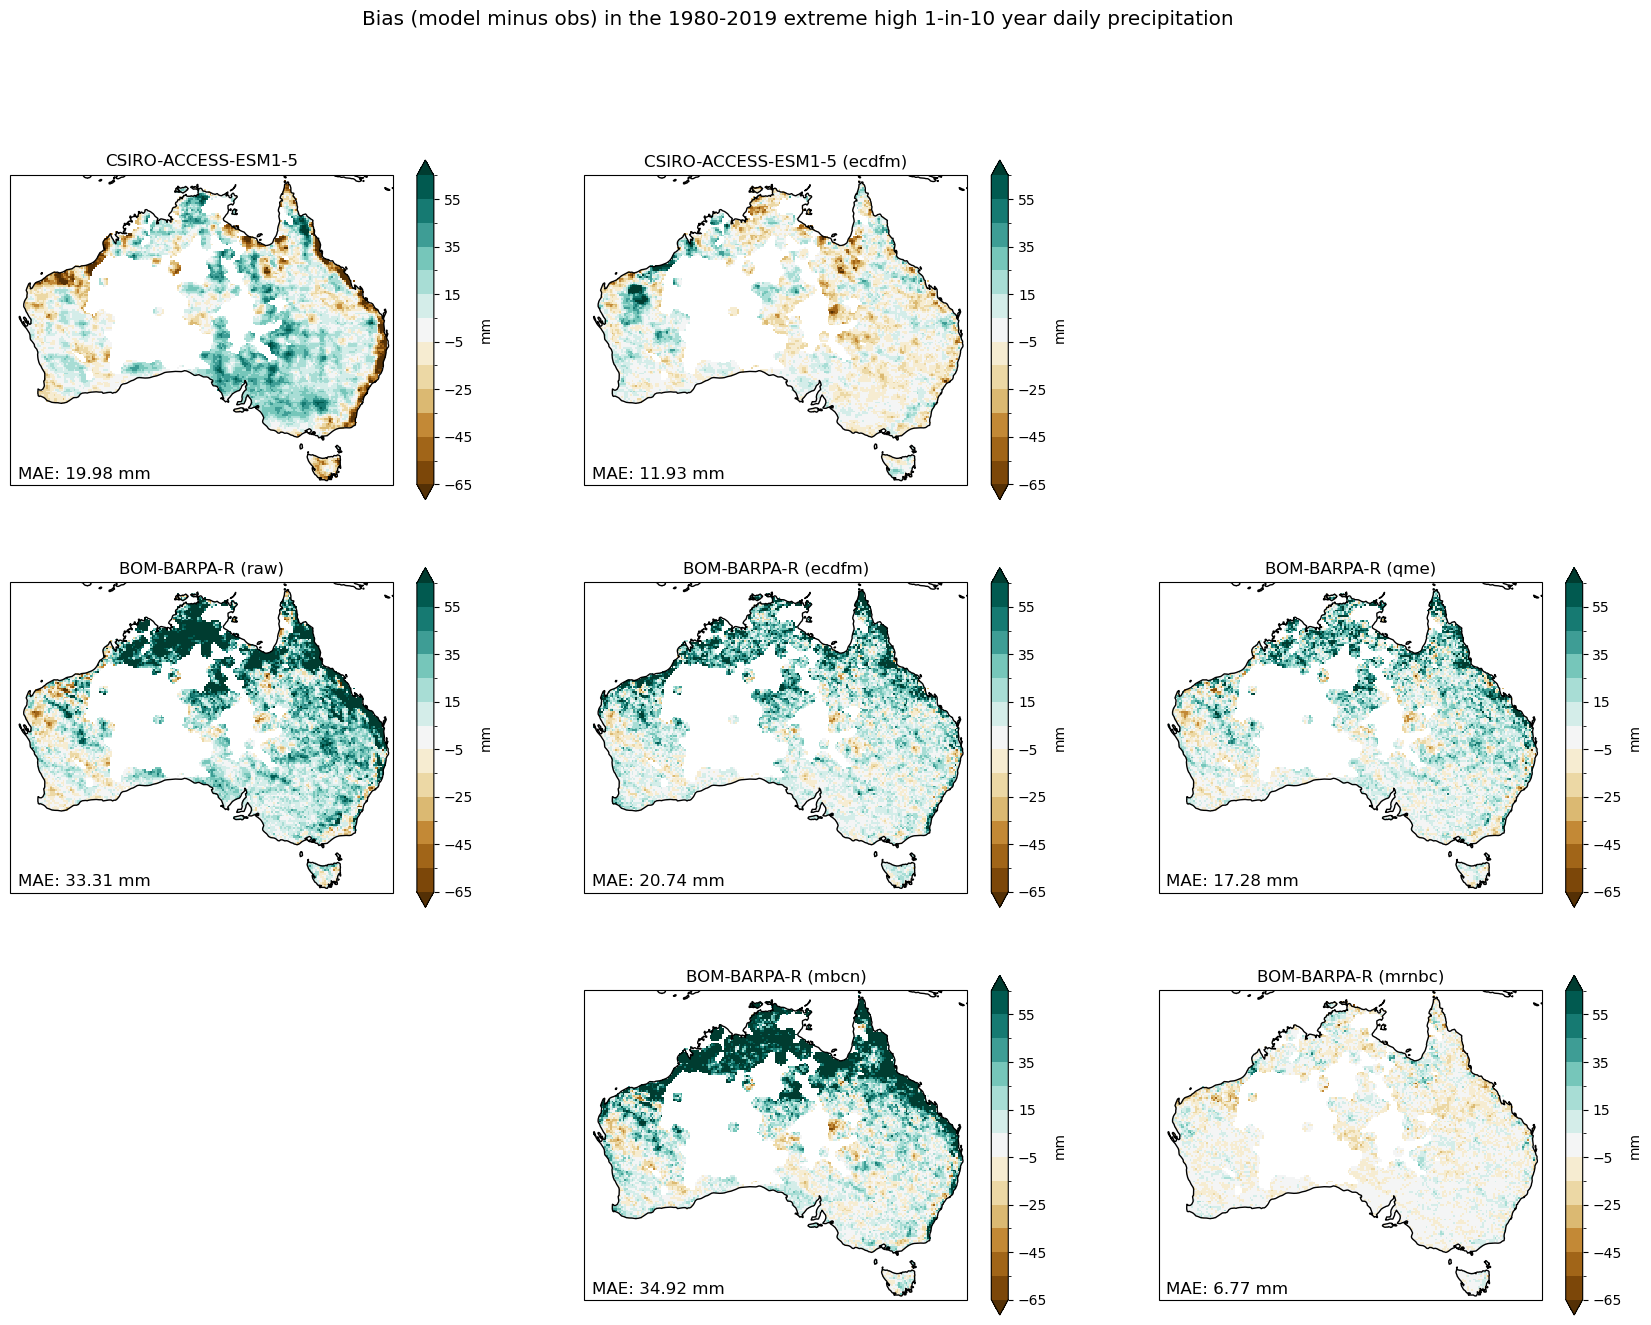

In [11]:
rcm = 'BOM-BARPA-R'
plot_rcm(da_obs, da_gcm, gcm_bc_dict, variable, gcm, rcm, task, start_date, end_date, save_outfile=False)

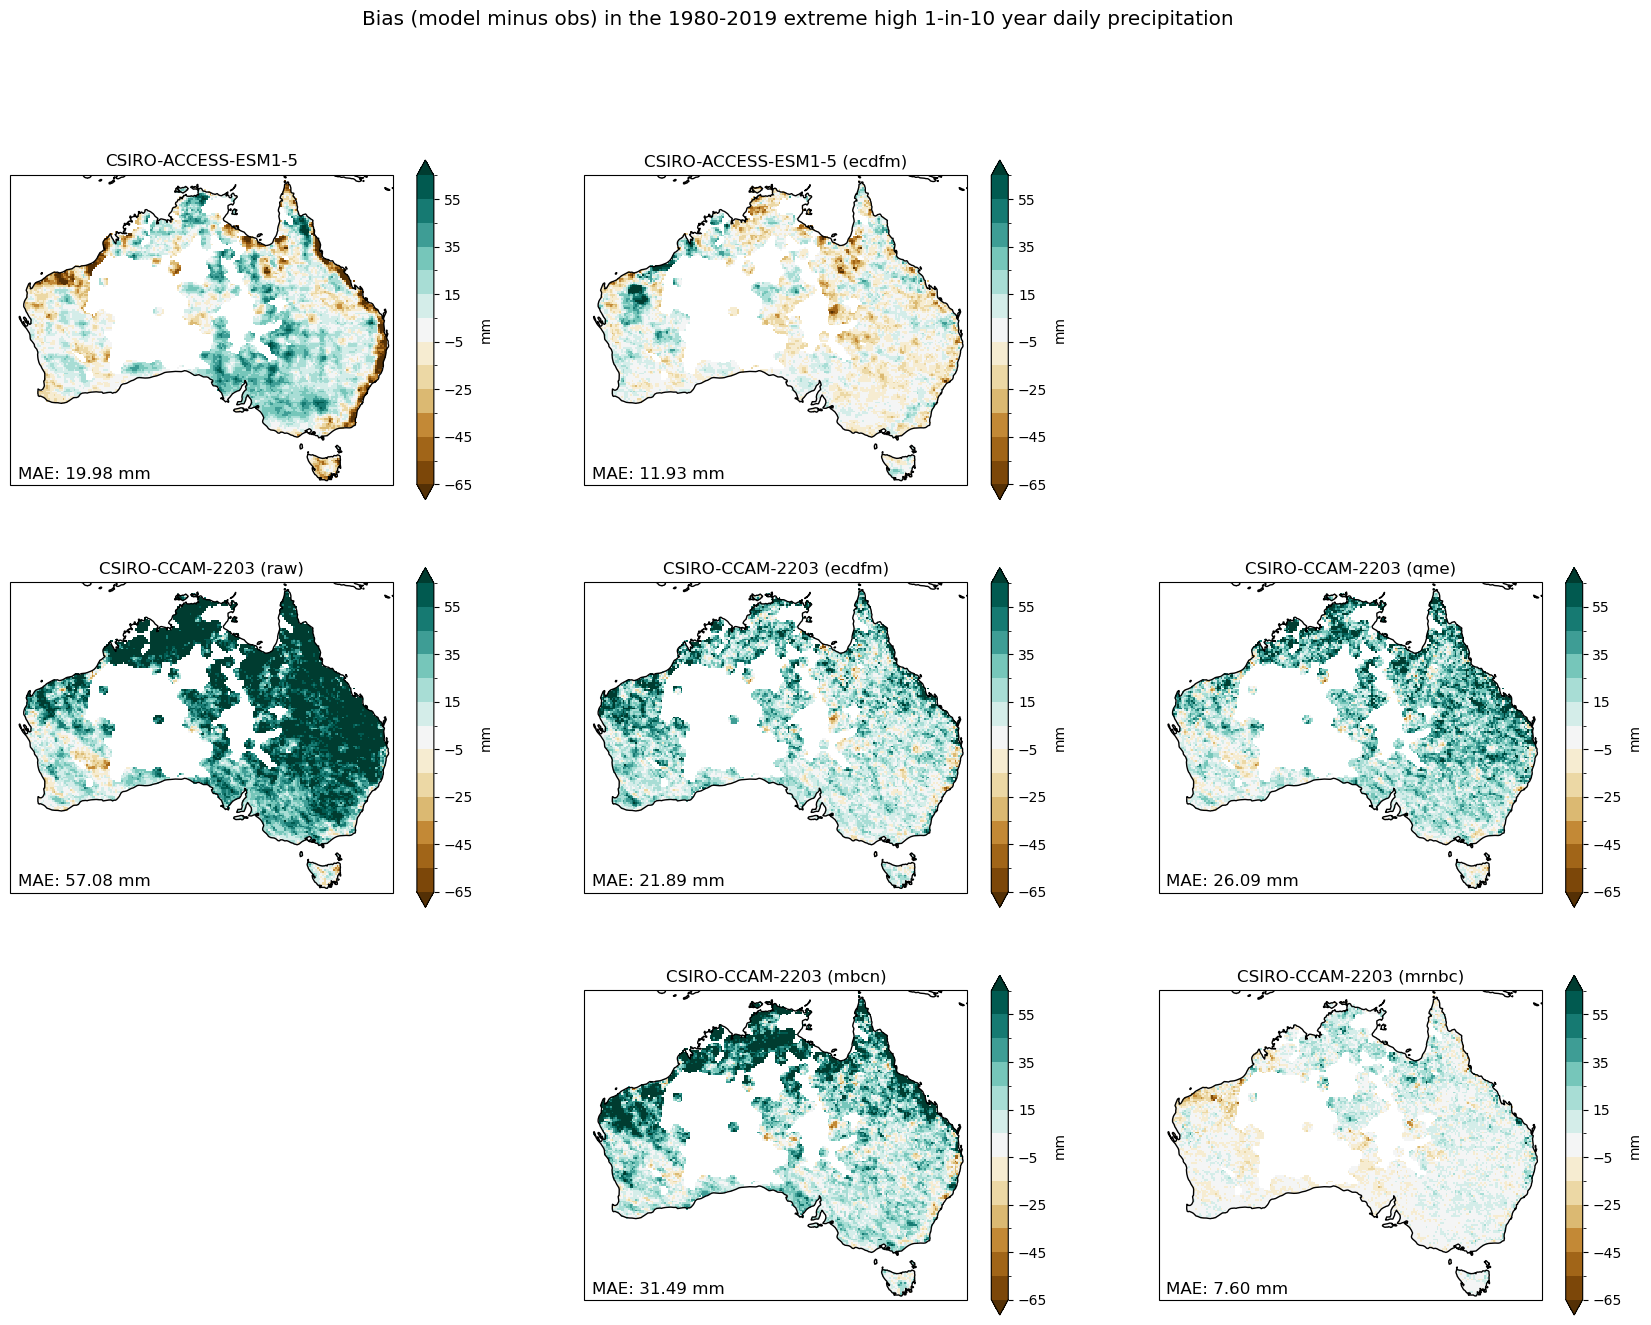

In [12]:
rcm = 'CSIRO-CCAM-2203'
plot_rcm(da_obs, da_gcm, gcm_bc_dict, variable, gcm, rcm, task, start_date, end_date)

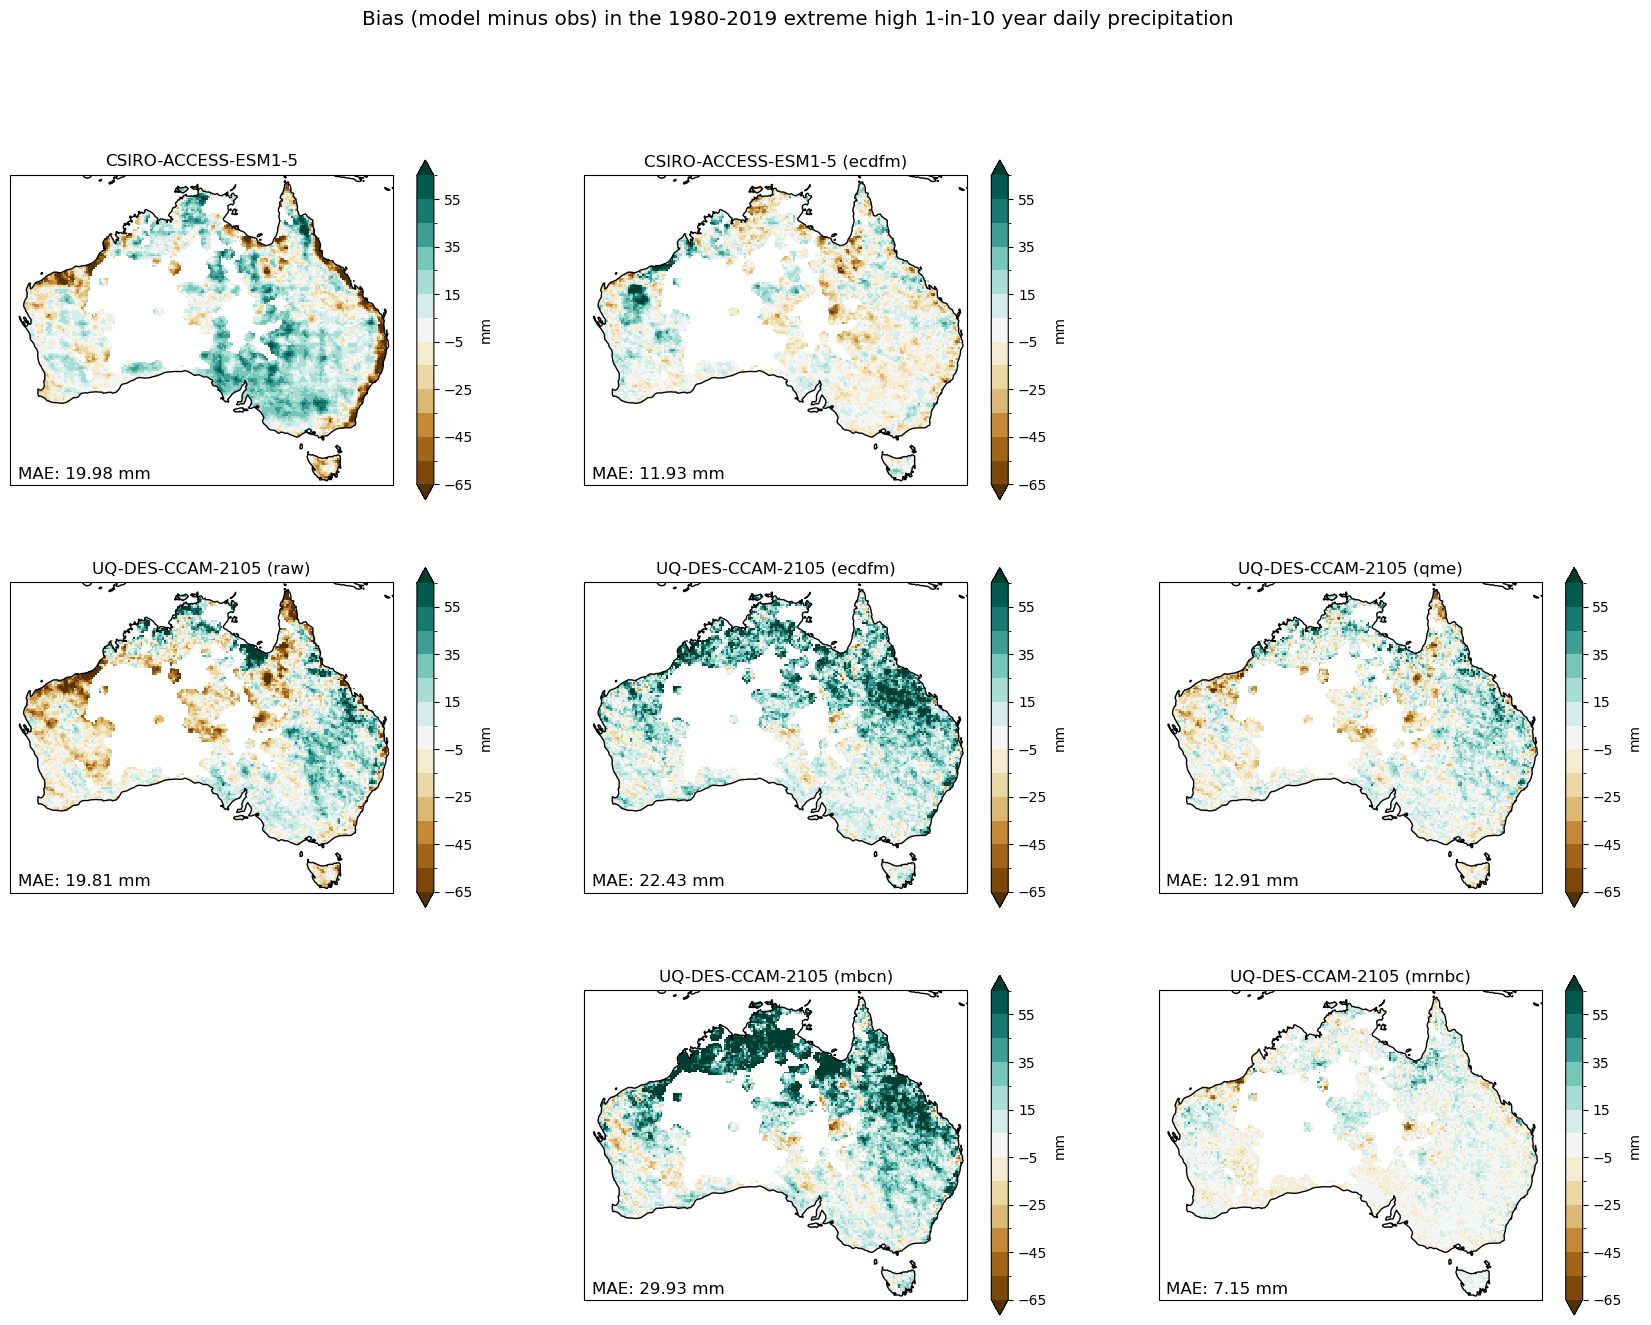

In [13]:
rcm = 'UQ-DES-CCAM-2105'
plot_rcm(da_obs, da_gcm, gcm_bc_dict, variable, gcm, rcm, task, start_date, end_date)

#### CESM2

In [14]:
gcm = 'NCAR-CESM2'
task = 'historical'
start_date, end_date = get_assessment_time_bounds(gcm, task)
da_obs = get_obs_data(variable, start_date, end_date)
da_gcm = get_gcm_data(variable, gcm, start_date, end_date)
gcm_bc_dict = get_bias_corrected_gcm_data(variable, gcm, task, start_date, end_date)

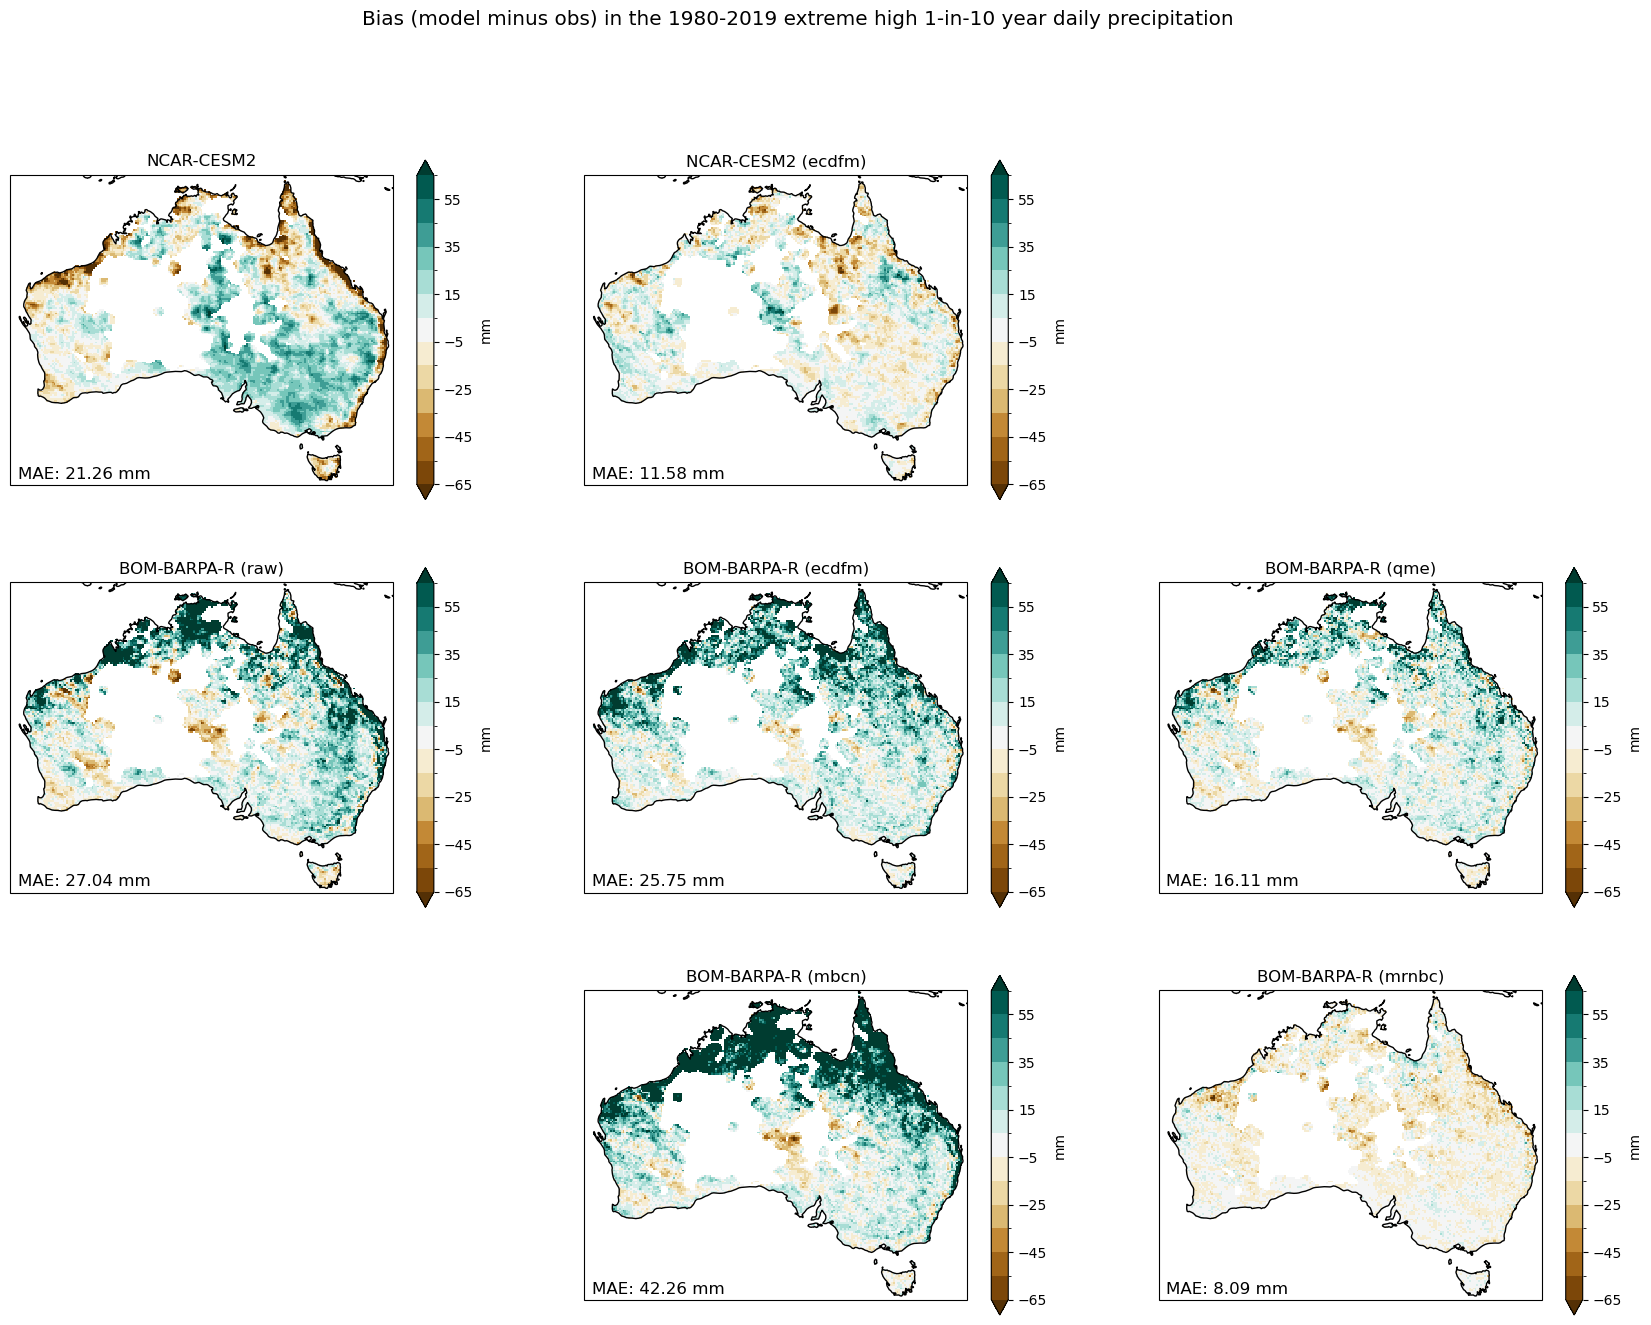

In [15]:
rcm = 'BOM-BARPA-R'
plot_rcm(da_obs, da_gcm, gcm_bc_dict, variable, gcm, rcm, task, start_date, end_date, save_outfile=False)

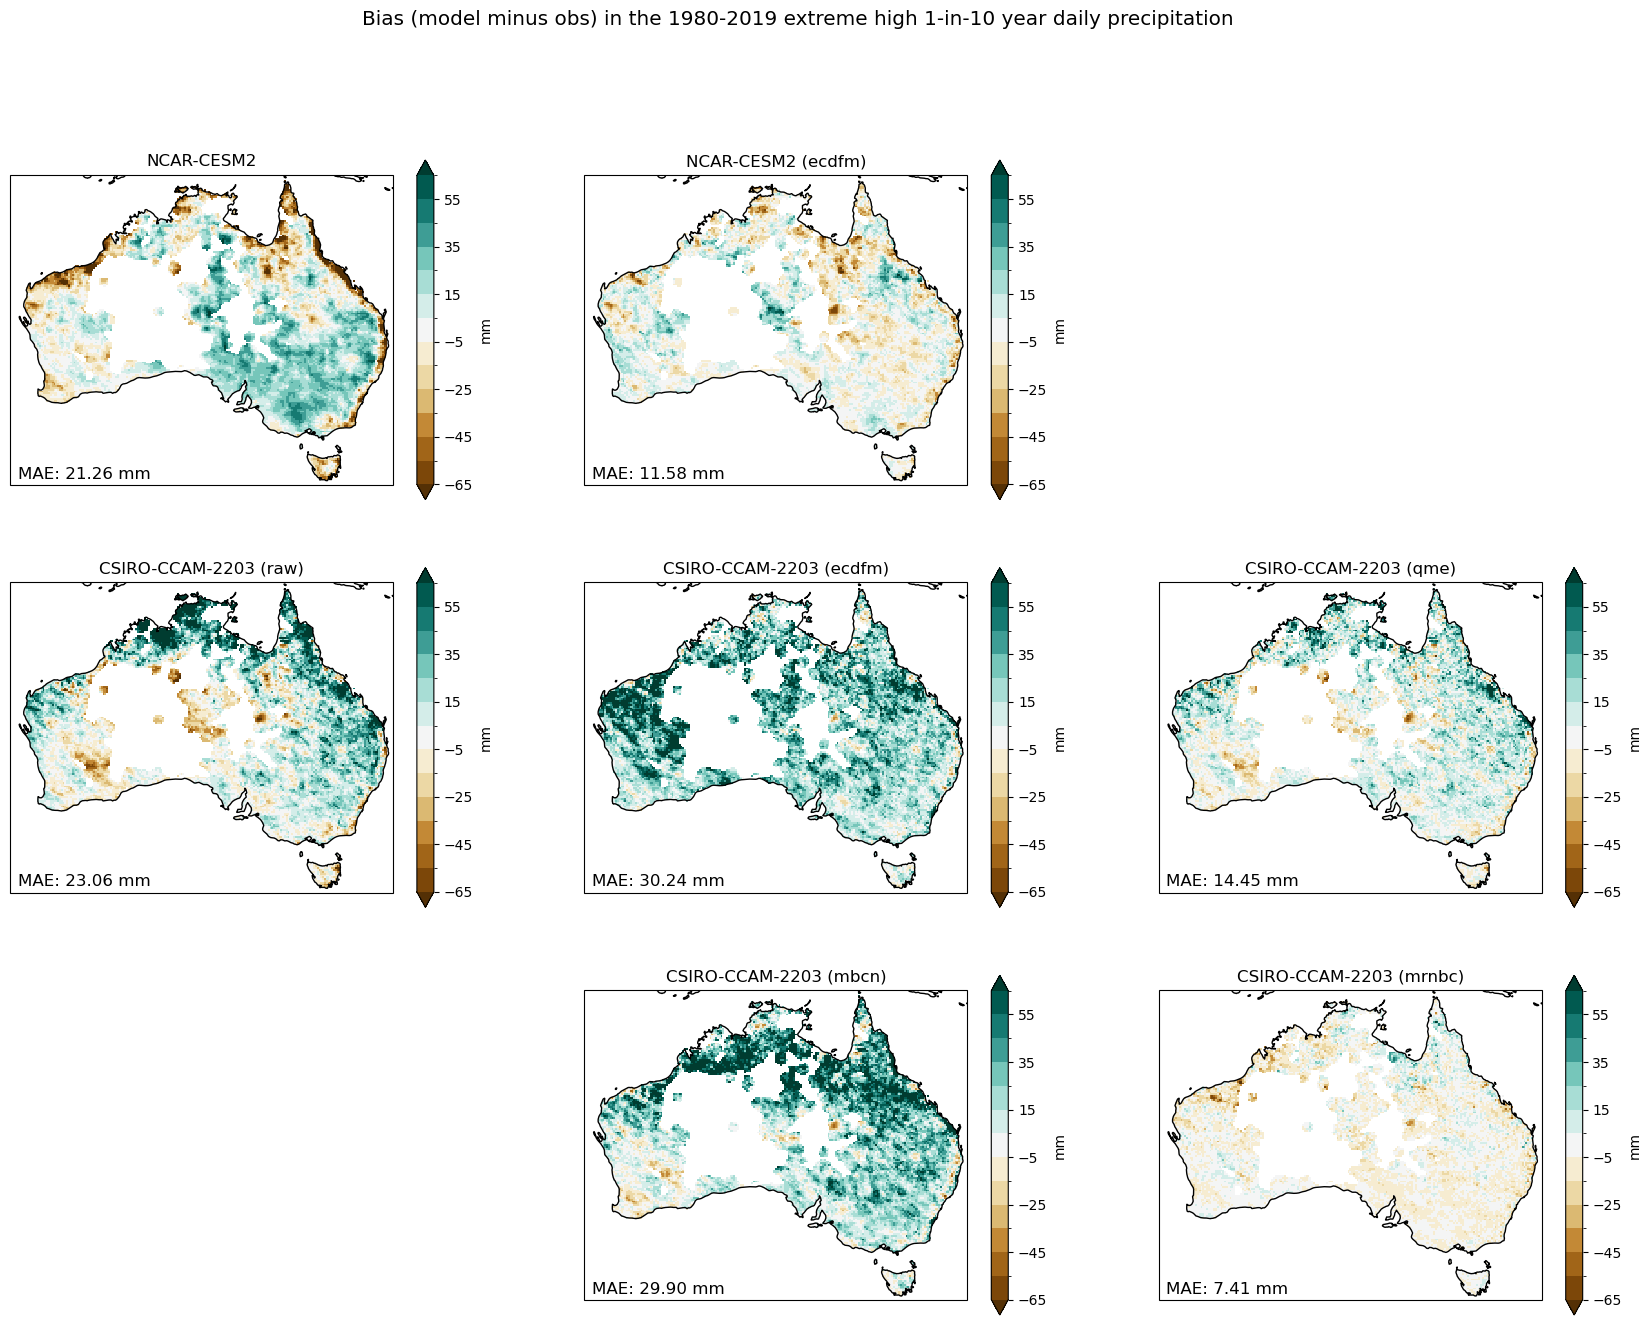

In [16]:
rcm = 'CSIRO-CCAM-2203'
plot_rcm(da_obs, da_gcm, gcm_bc_dict, variable, gcm, rcm, task, start_date, end_date)

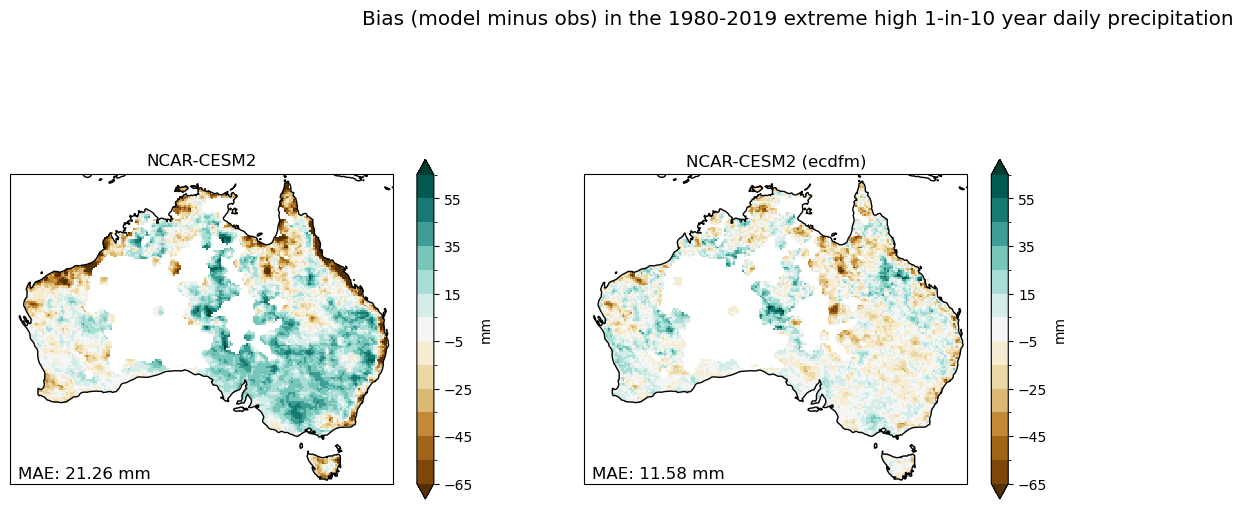

In [17]:
rcm = 'UQ-DES-CCAM-2105'
plot_rcm(da_obs, da_gcm, gcm_bc_dict, variable, gcm, rcm, task, start_date, end_date)

#### EC-Earth3

In [18]:
gcm = 'EC-Earth-Consortium-EC-Earth3'
task = 'historical'
start_date, end_date = get_assessment_time_bounds(gcm, task)
da_obs = get_obs_data(variable, start_date, end_date)
da_gcm = get_gcm_data(variable, gcm, start_date, end_date)
gcm_bc_dict = get_bias_corrected_gcm_data(variable, gcm, task, start_date, end_date)

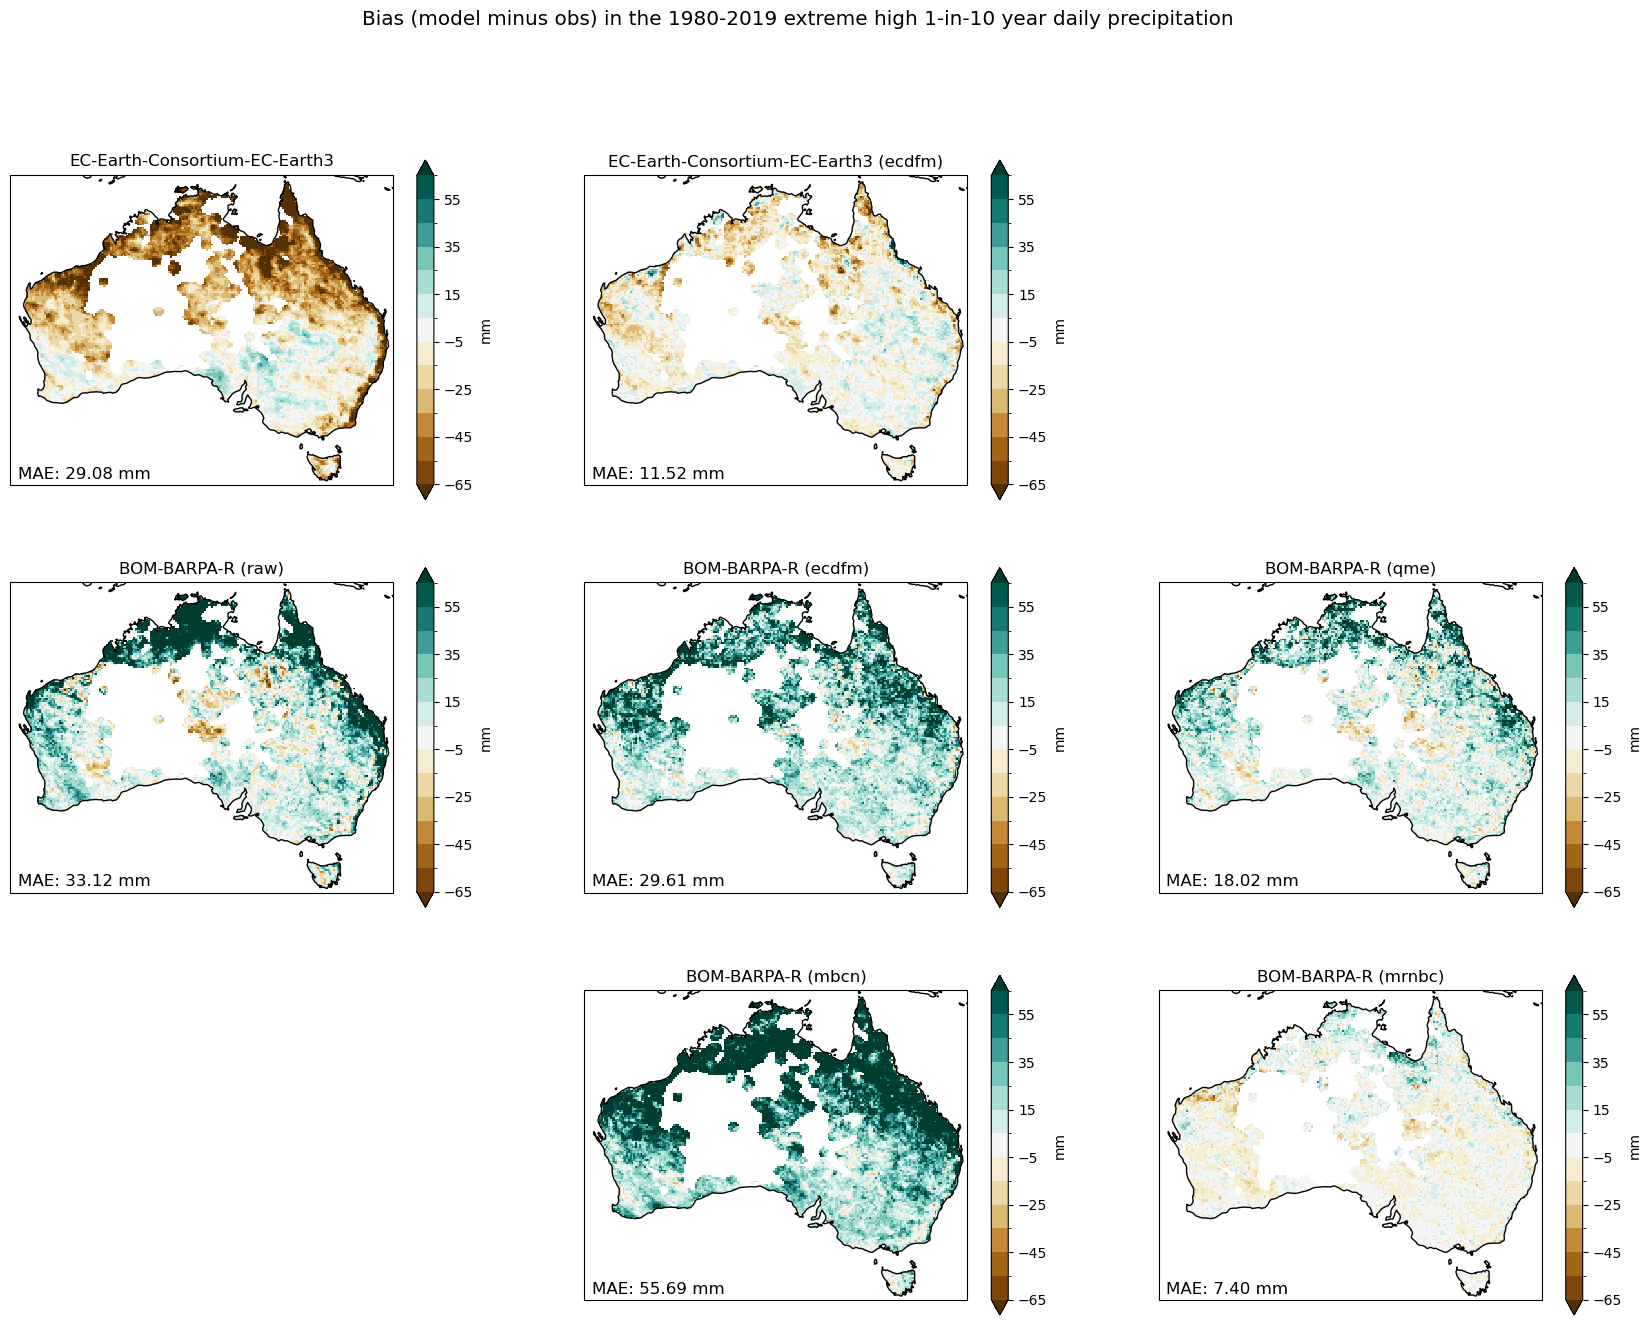

In [19]:
rcm = 'BOM-BARPA-R'
plot_rcm(da_obs, da_gcm, gcm_bc_dict, variable, gcm, rcm, task, start_date, end_date, save_outfile=False)

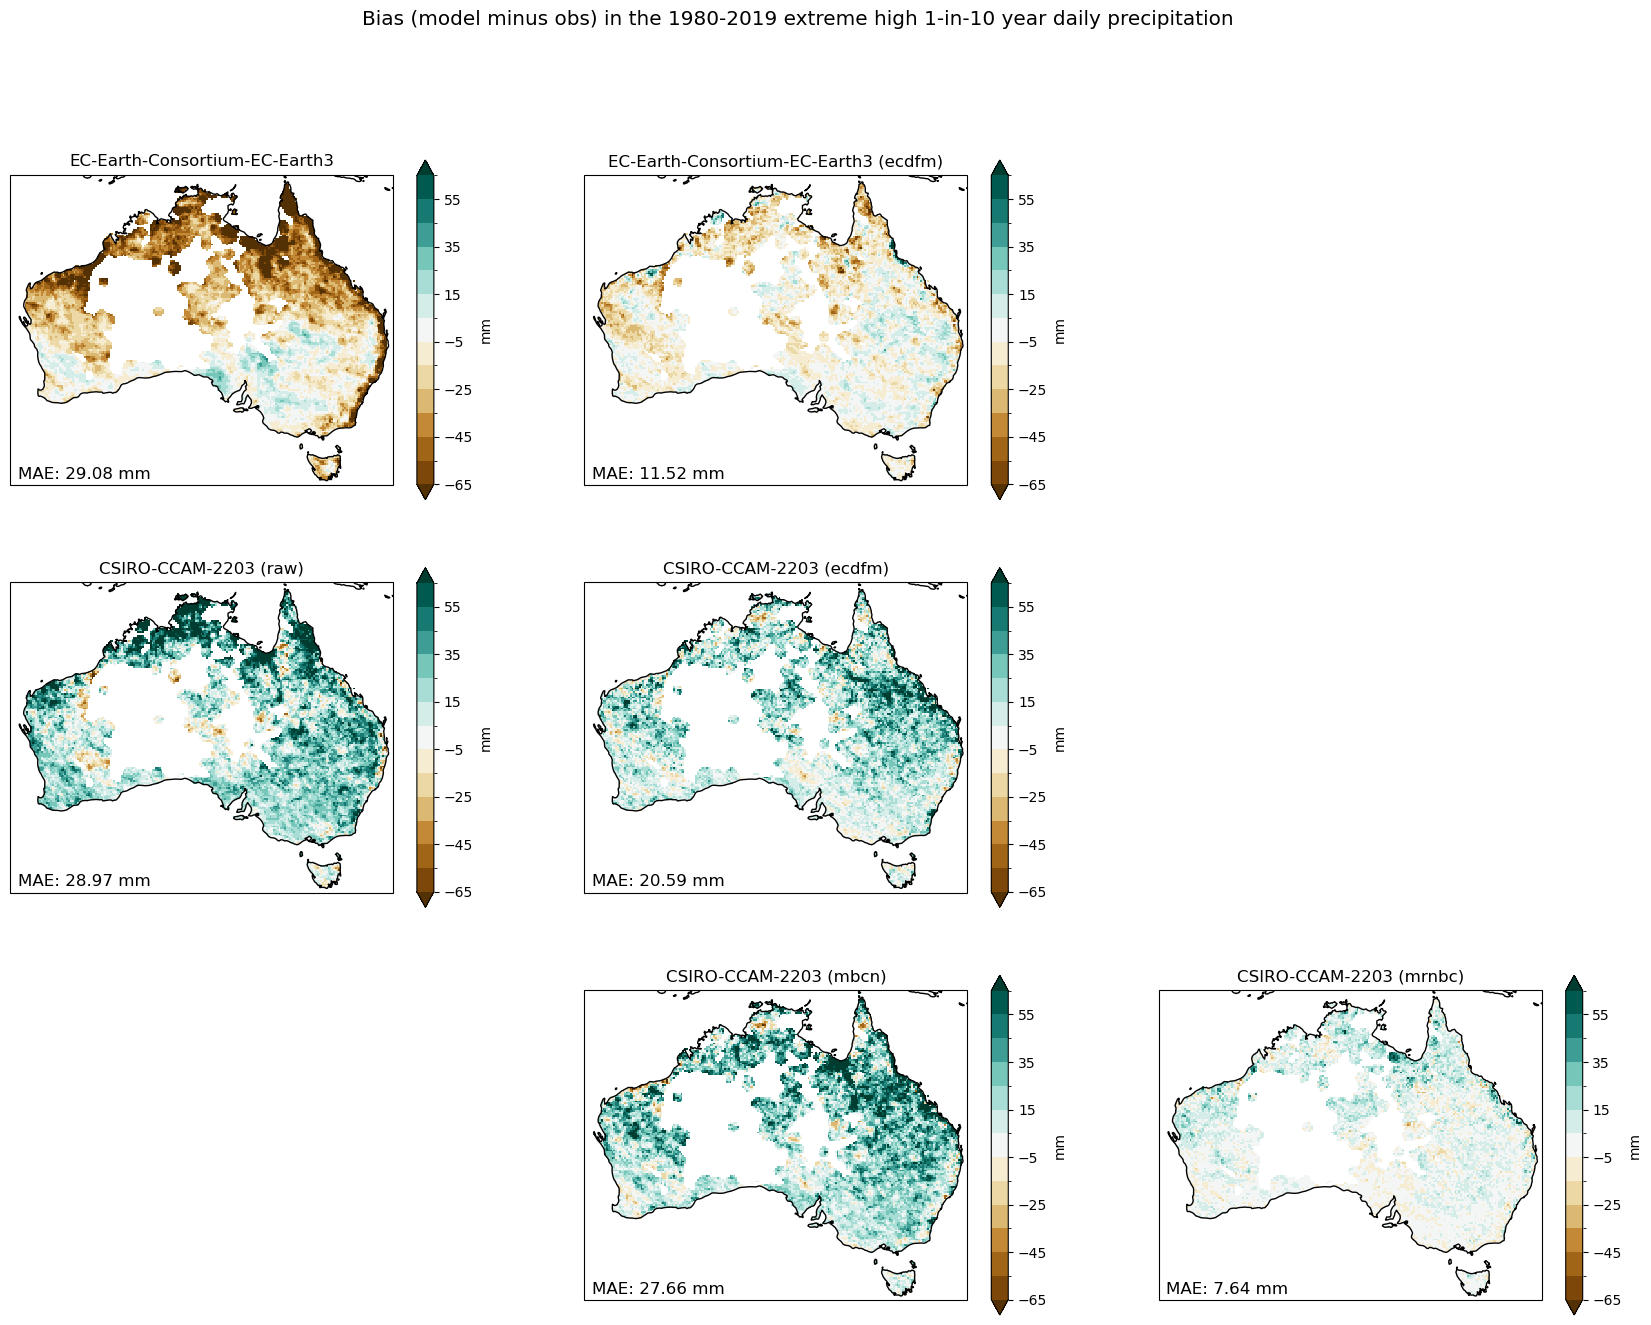

In [20]:
rcm = 'CSIRO-CCAM-2203'
plot_rcm(da_obs, da_gcm, gcm_bc_dict, variable, gcm, rcm, task, start_date, end_date)

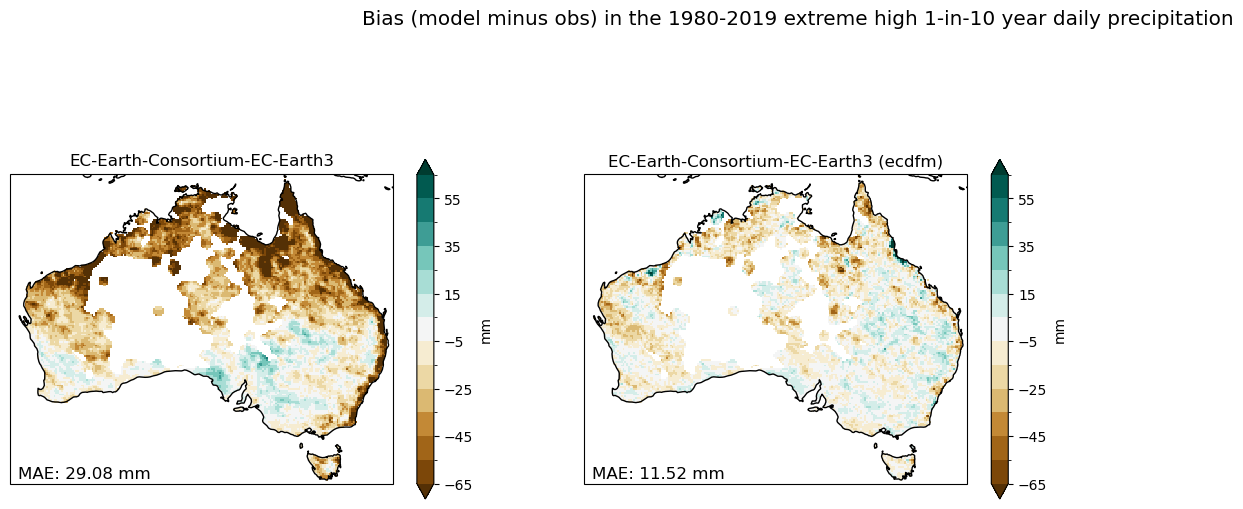

In [21]:
rcm = 'UQ-DES-CCAM-2105'
plot_rcm(da_obs, da_gcm, gcm_bc_dict, variable, gcm, rcm, task, start_date, end_date)

## task-xvalidation

#### ERA5

Bias corrected data for the 2000-2019 period, using 1980-1999 as a training period.

In [22]:
#gcm = 'ECMWF-ERA5'
#task = 'xvalidation'
#start_date, end_date = get_assessment_time_bounds(gcm, task)
#da_obs = get_obs_data(variable, start_date, end_date)
#da_gcm = get_gcm_data(variable, gcm, start_date, end_date)
#gcm_bc_dict = get_bias_corrected_gcm_data(variable, gcm, task, start_date, end_date)

#training_start, training_end = get_training_time_bounds(gcm)
#da_training_obs = get_obs_data(variable, training_start, training_end)

In [23]:
#rcm = 'BOM-BARPA-R'
#plot_rcm(da_obs, da_gcm, gcm_bc_dict, variable, gcm, rcm, task, start_date, end_date, da_training_obs)

In [24]:
#rcm = 'CSIRO-CCAM-2203'
#plot_rcm(da_obs, da_gcm, gcm_bc_dict, variable, gcm, rcm, task, start_date, end_date, da_training_obs)

In [25]:
#rcm = 'UQ-DES-CCAM-2105'
#plot_rcm(da_obs, da_gcm, gcm_bc_dict, variable, gcm, rcm, task, start_date, end_date, da_training_obs)

#### ACCESS-ESM1-5

Bias corrected data for the 1990-2019 period, using 1960-1989 as a training period.

In [26]:
gcm = 'CSIRO-ACCESS-ESM1-5'
task = 'xvalidation'
start_date, end_date = get_assessment_time_bounds(gcm, task)
da_obs = get_obs_data(variable, start_date, end_date)
da_gcm = get_gcm_data(variable, gcm, start_date, end_date)
gcm_bc_dict = get_bias_corrected_gcm_data(variable, gcm, task, start_date, end_date)

training_start, training_end = get_training_time_bounds(gcm)
da_training_obs = get_obs_data(variable, training_start, training_end)

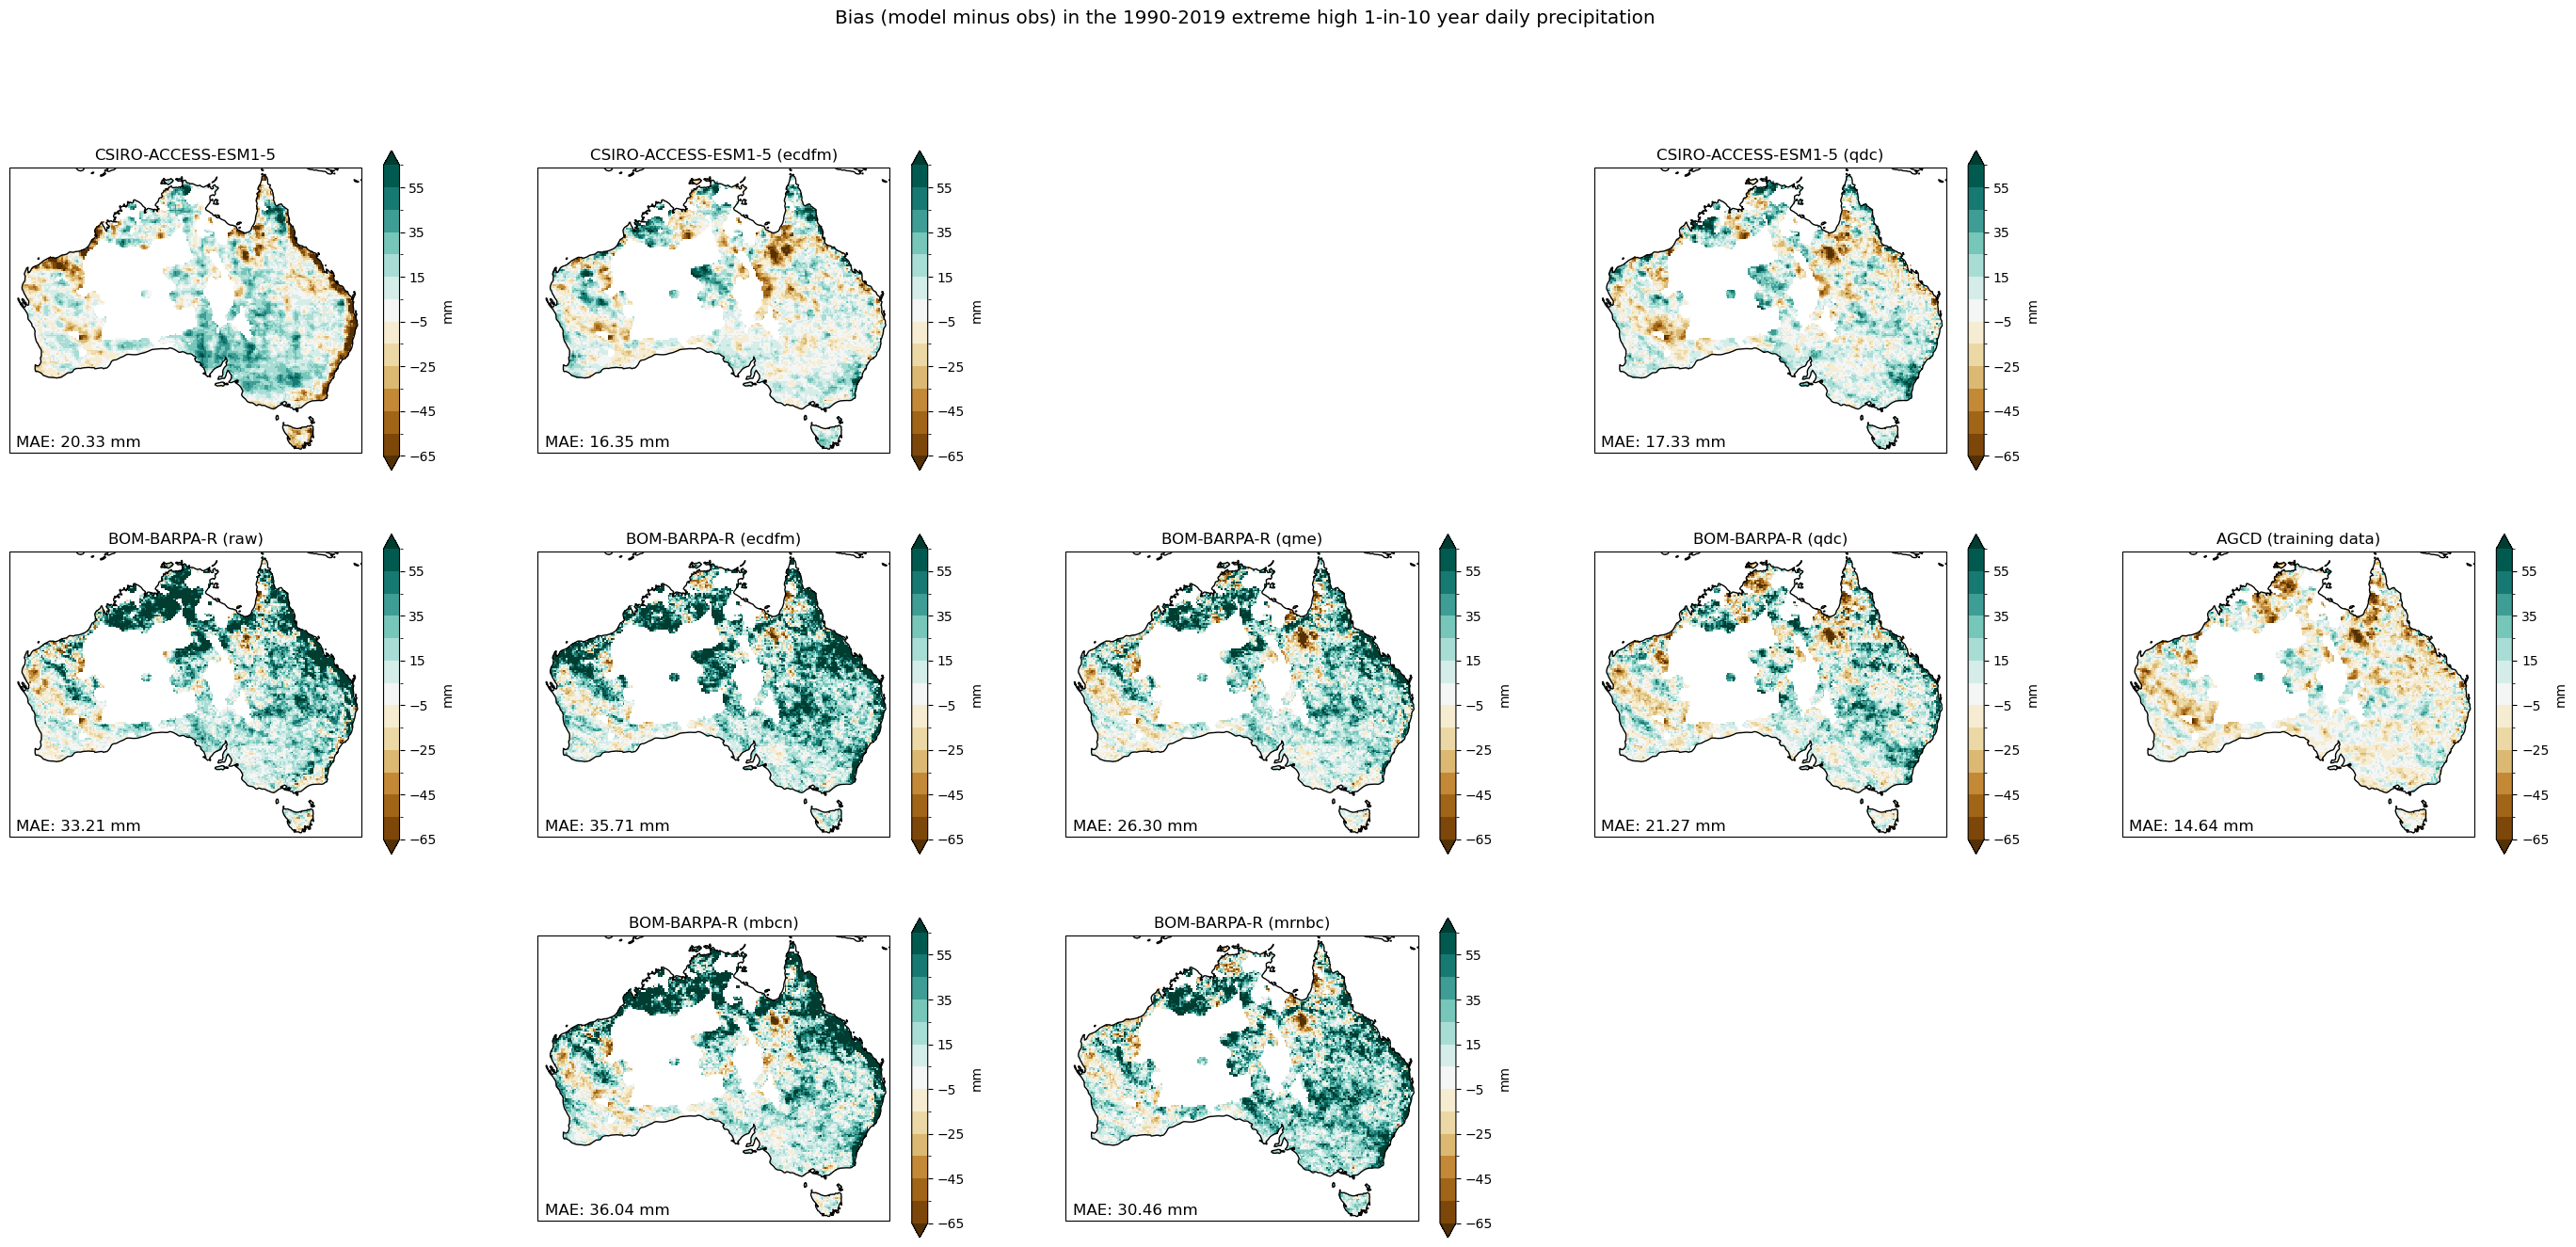

In [27]:
rcm = 'BOM-BARPA-R'
plot_rcm(da_obs, da_gcm, gcm_bc_dict, variable, gcm, rcm, task, start_date, end_date, da_training_obs, save_outfile=False)

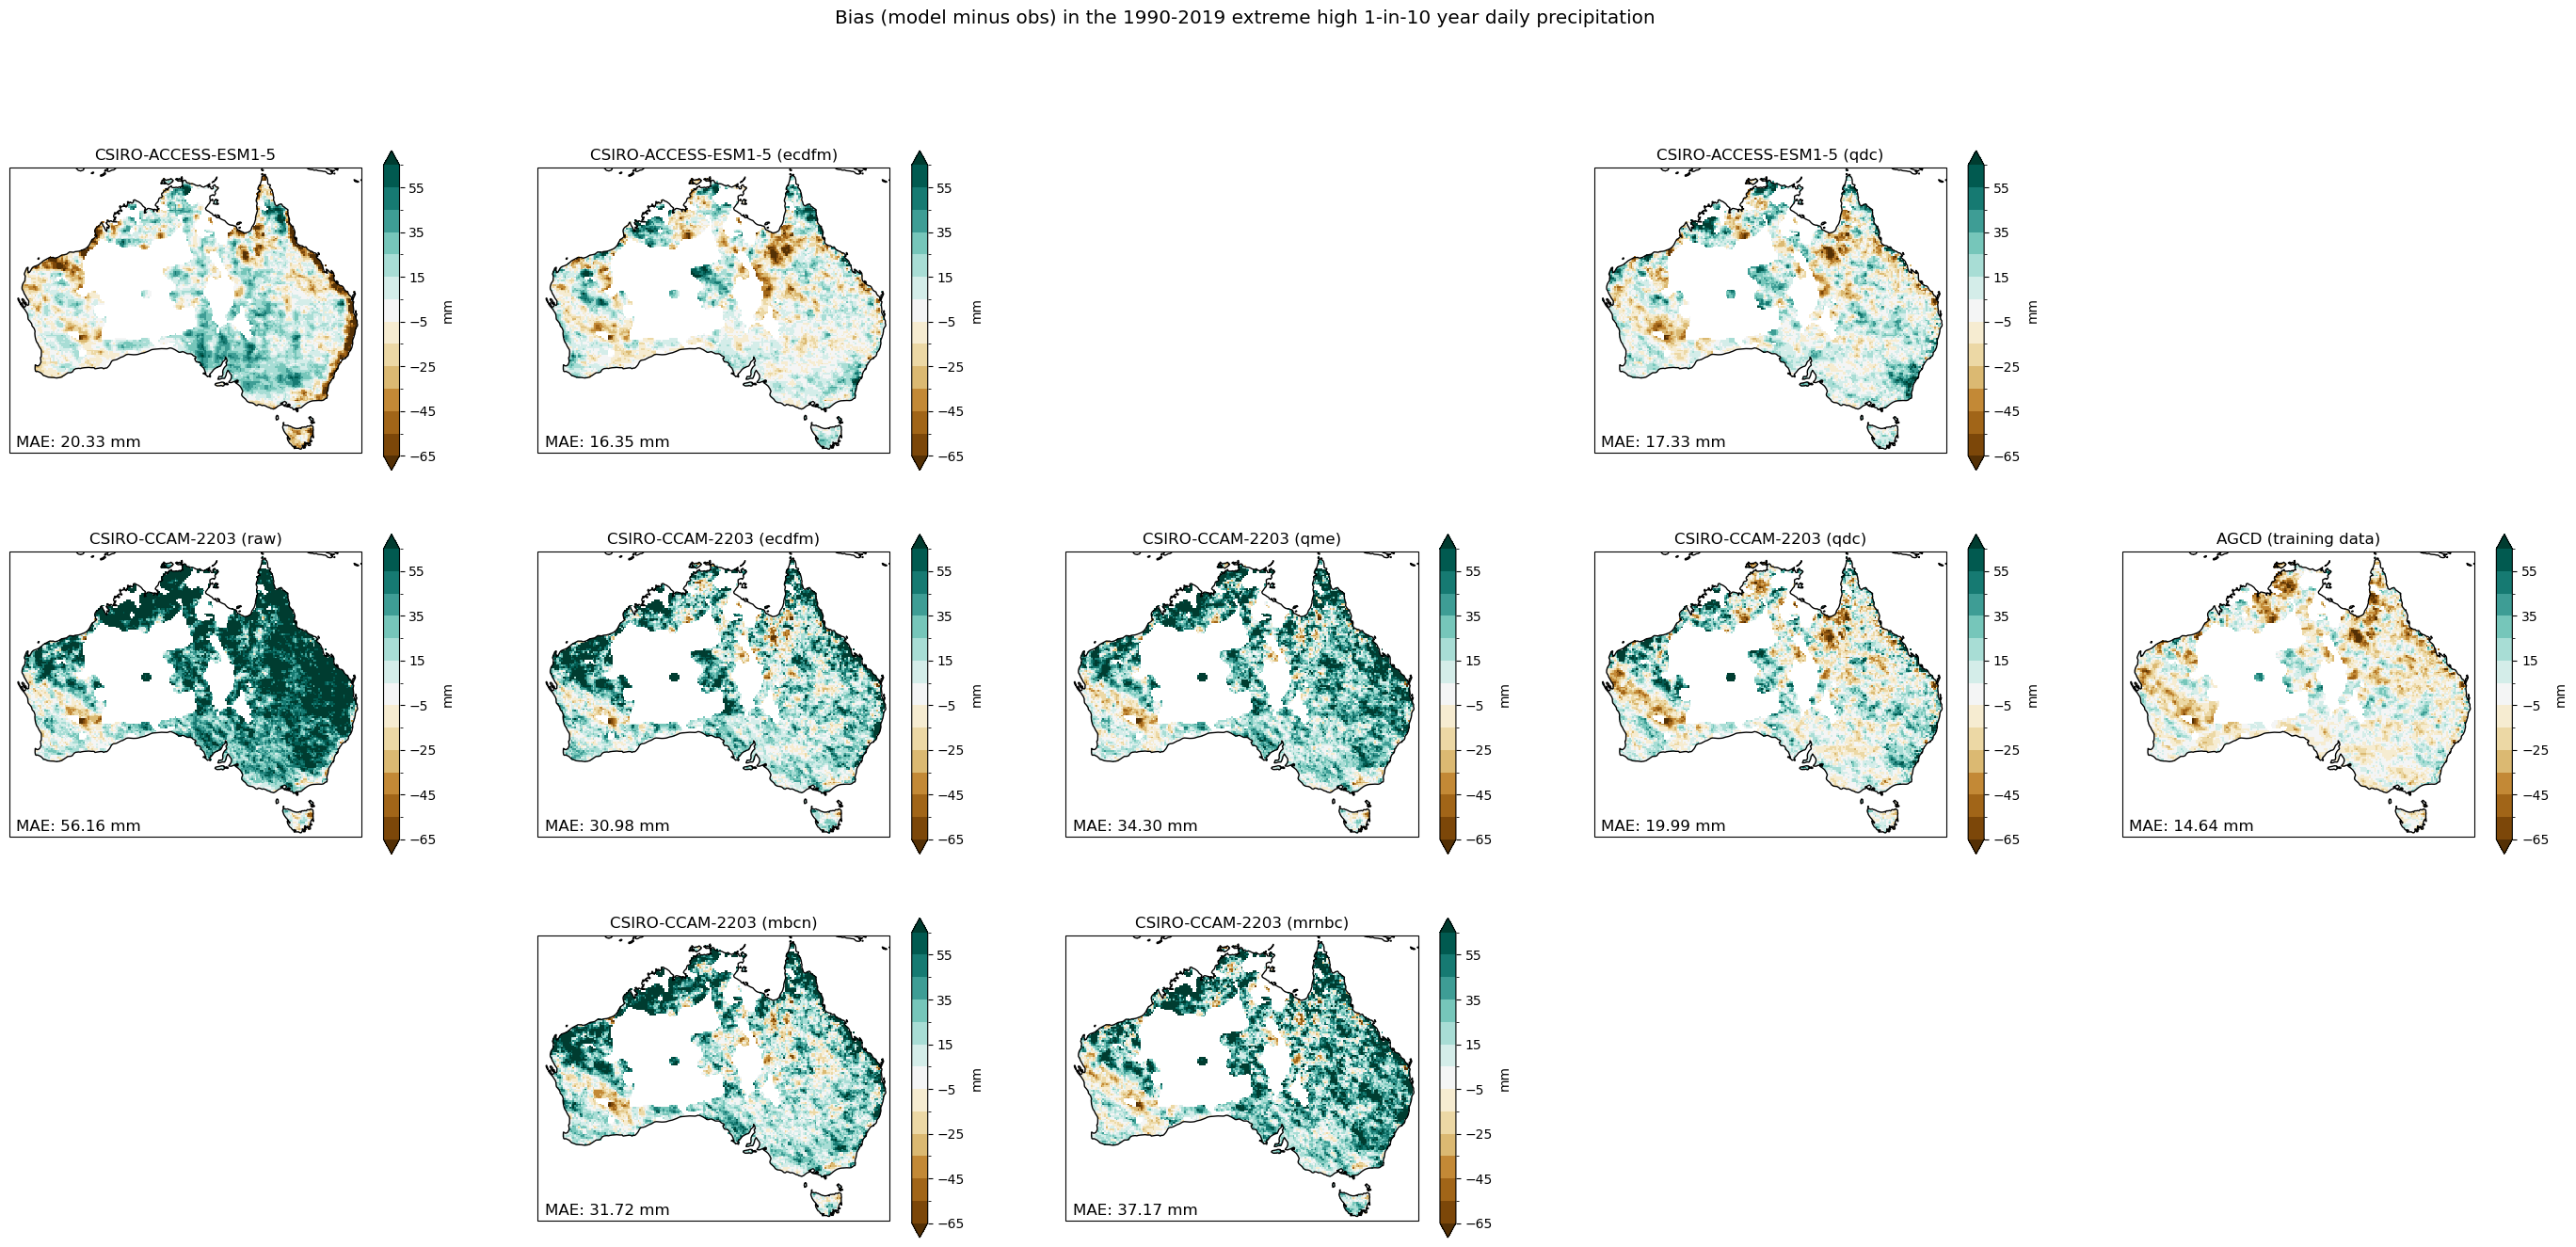

In [28]:
rcm = 'CSIRO-CCAM-2203'
plot_rcm(da_obs, da_gcm, gcm_bc_dict, variable, gcm, rcm, task, start_date, end_date, da_training_obs, save_outfile=False)

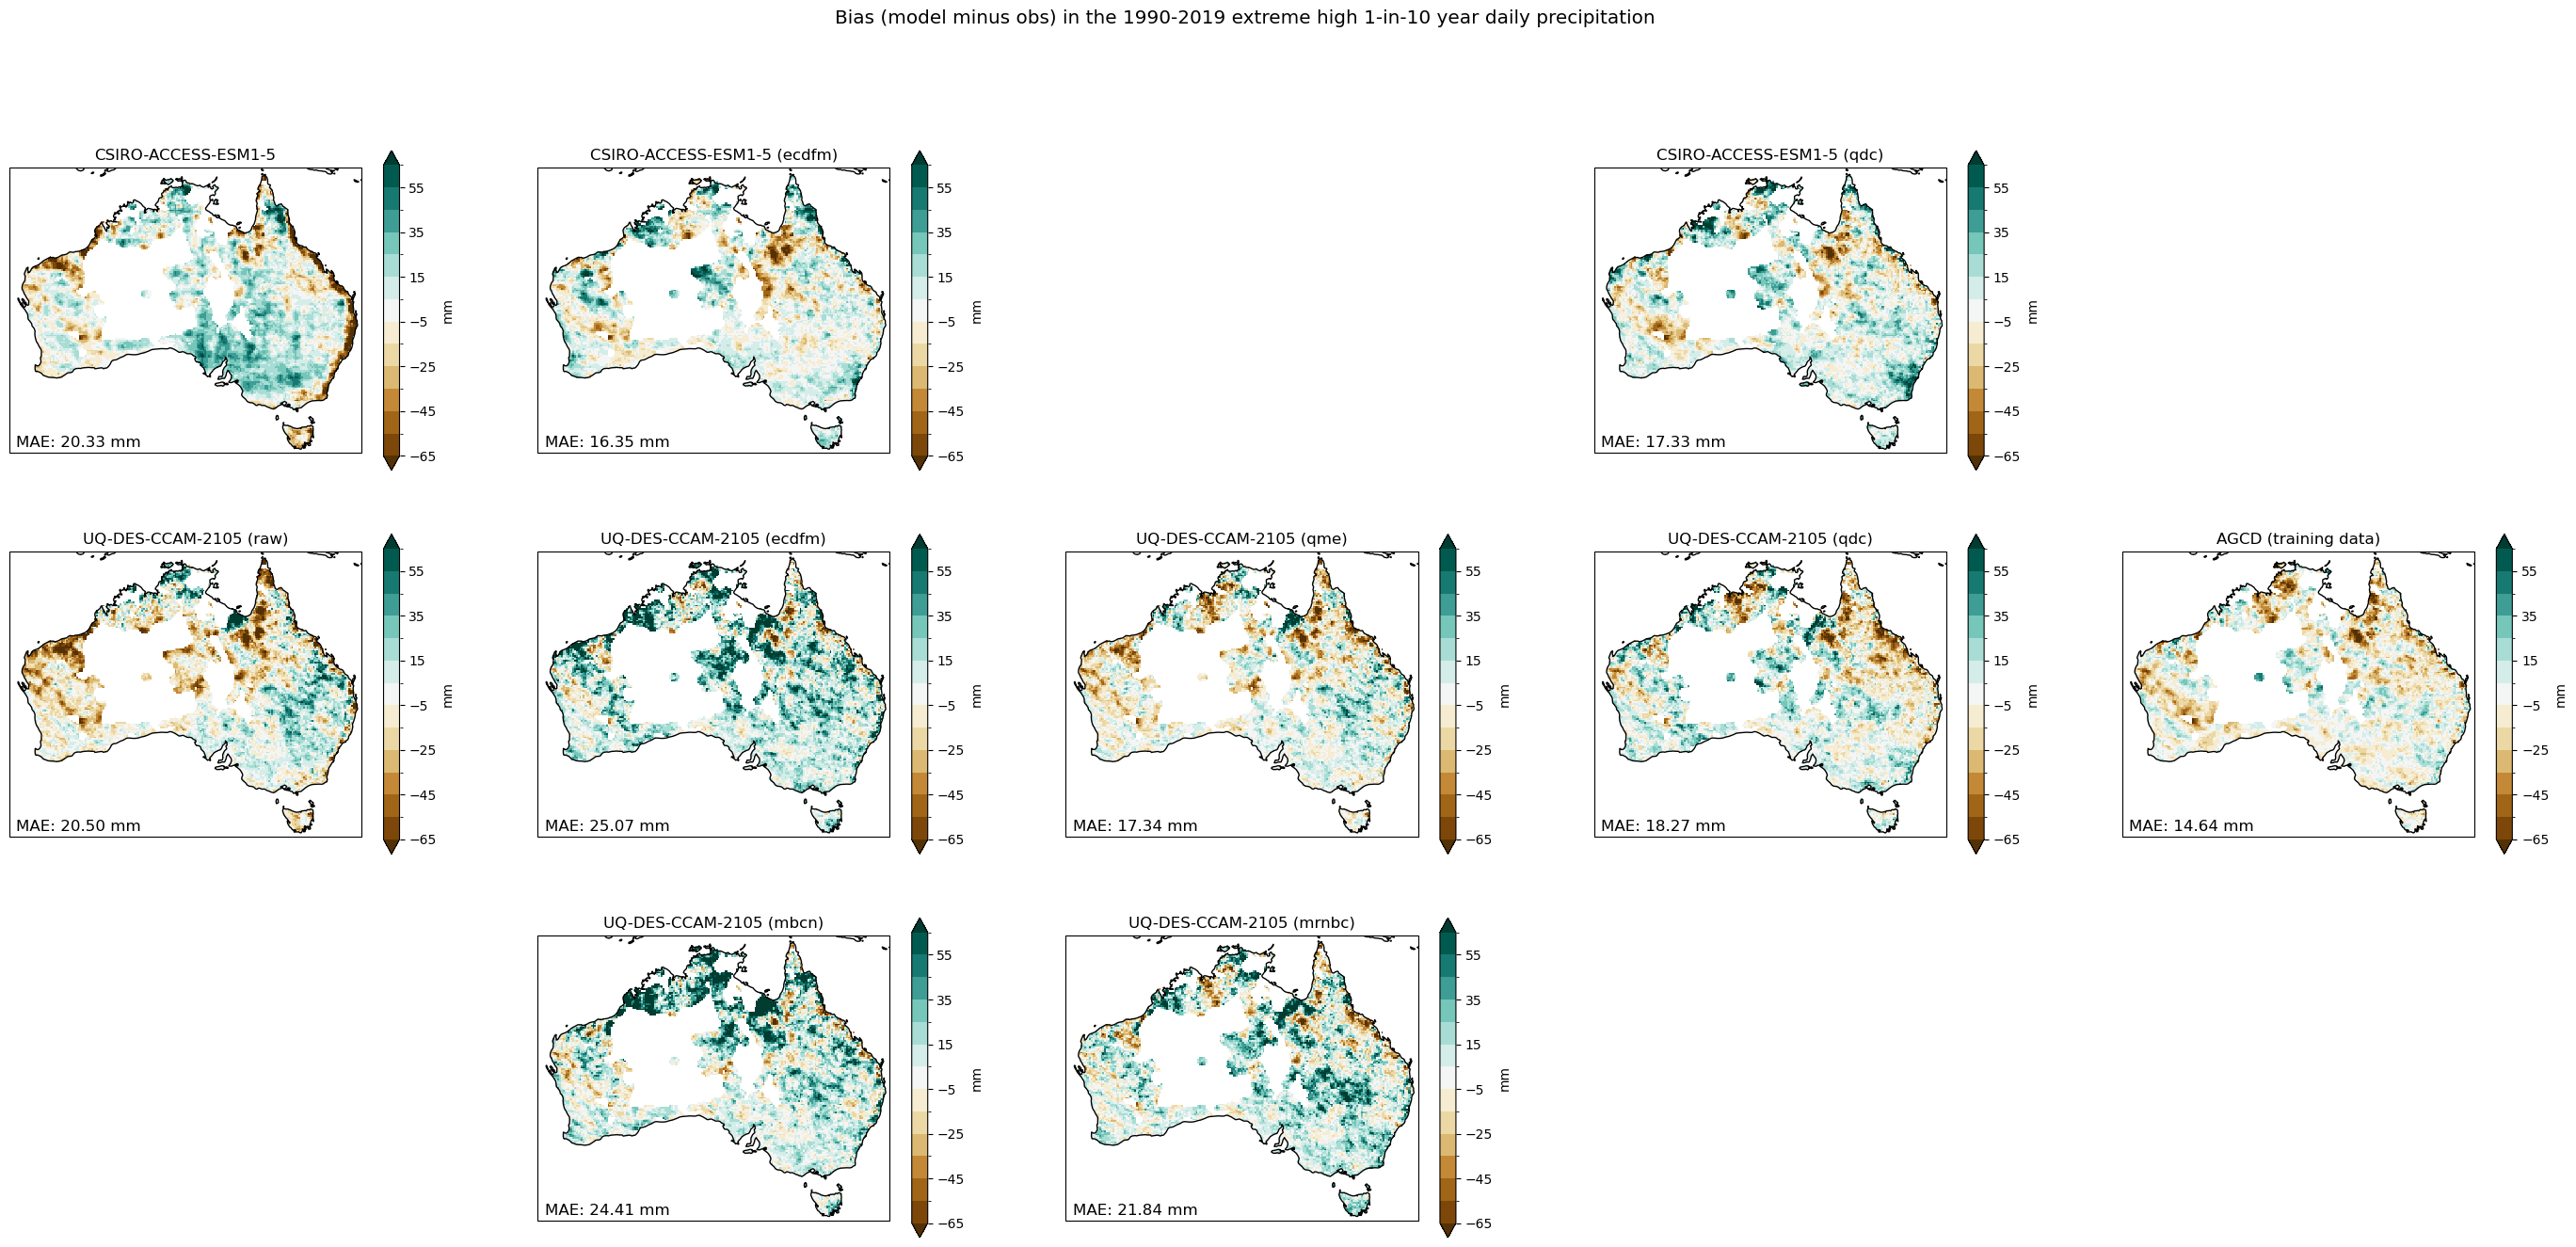

In [29]:
rcm = 'UQ-DES-CCAM-2105'
plot_rcm(da_obs, da_gcm, gcm_bc_dict, variable, gcm, rcm, task, start_date, end_date, da_training_obs, save_outfile=False)

#### CESM2

Bias corrected data for the 1990-2019 period, using 1960-1989 as a training period.

In [30]:
gcm = 'NCAR-CESM2'
task = 'xvalidation'
start_date, end_date = get_assessment_time_bounds(gcm, task)
da_obs = get_obs_data(variable, start_date, end_date)
da_gcm = get_gcm_data(variable, gcm, start_date, end_date)
gcm_bc_dict = get_bias_corrected_gcm_data(variable, gcm, task, start_date, end_date)

training_start, training_end = get_training_time_bounds(gcm)
da_training_obs = get_obs_data(variable, training_start, training_end)

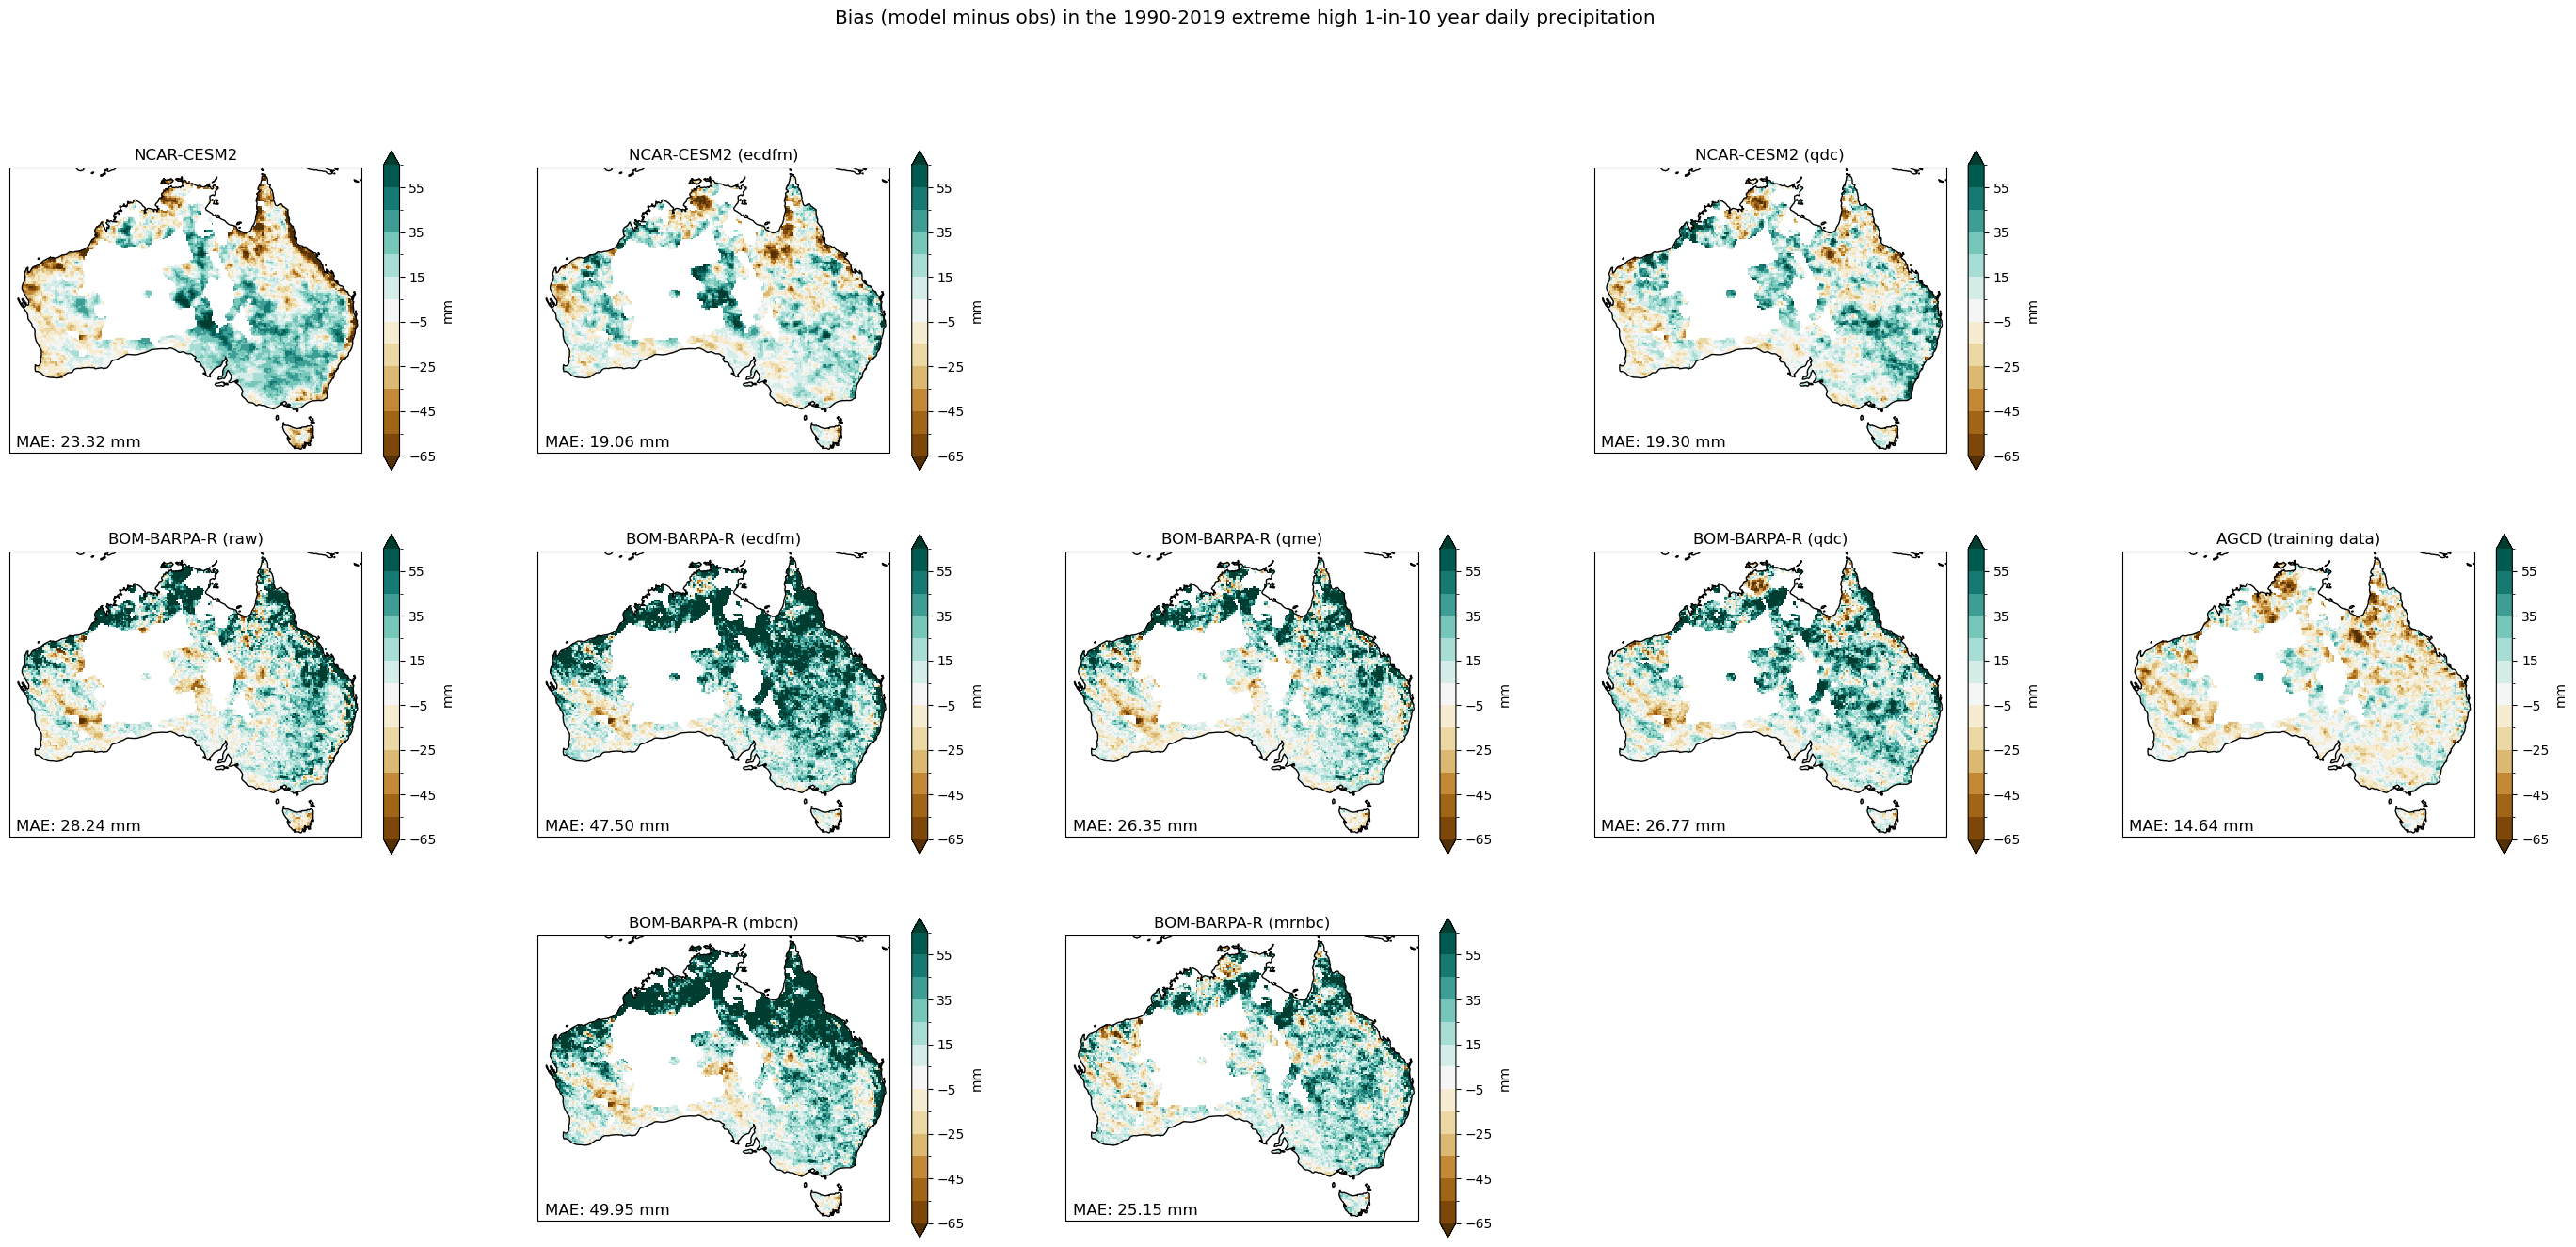

In [31]:
rcm = 'BOM-BARPA-R'
plot_rcm(da_obs, da_gcm, gcm_bc_dict, variable, gcm, rcm, task, start_date, end_date, da_training_obs)

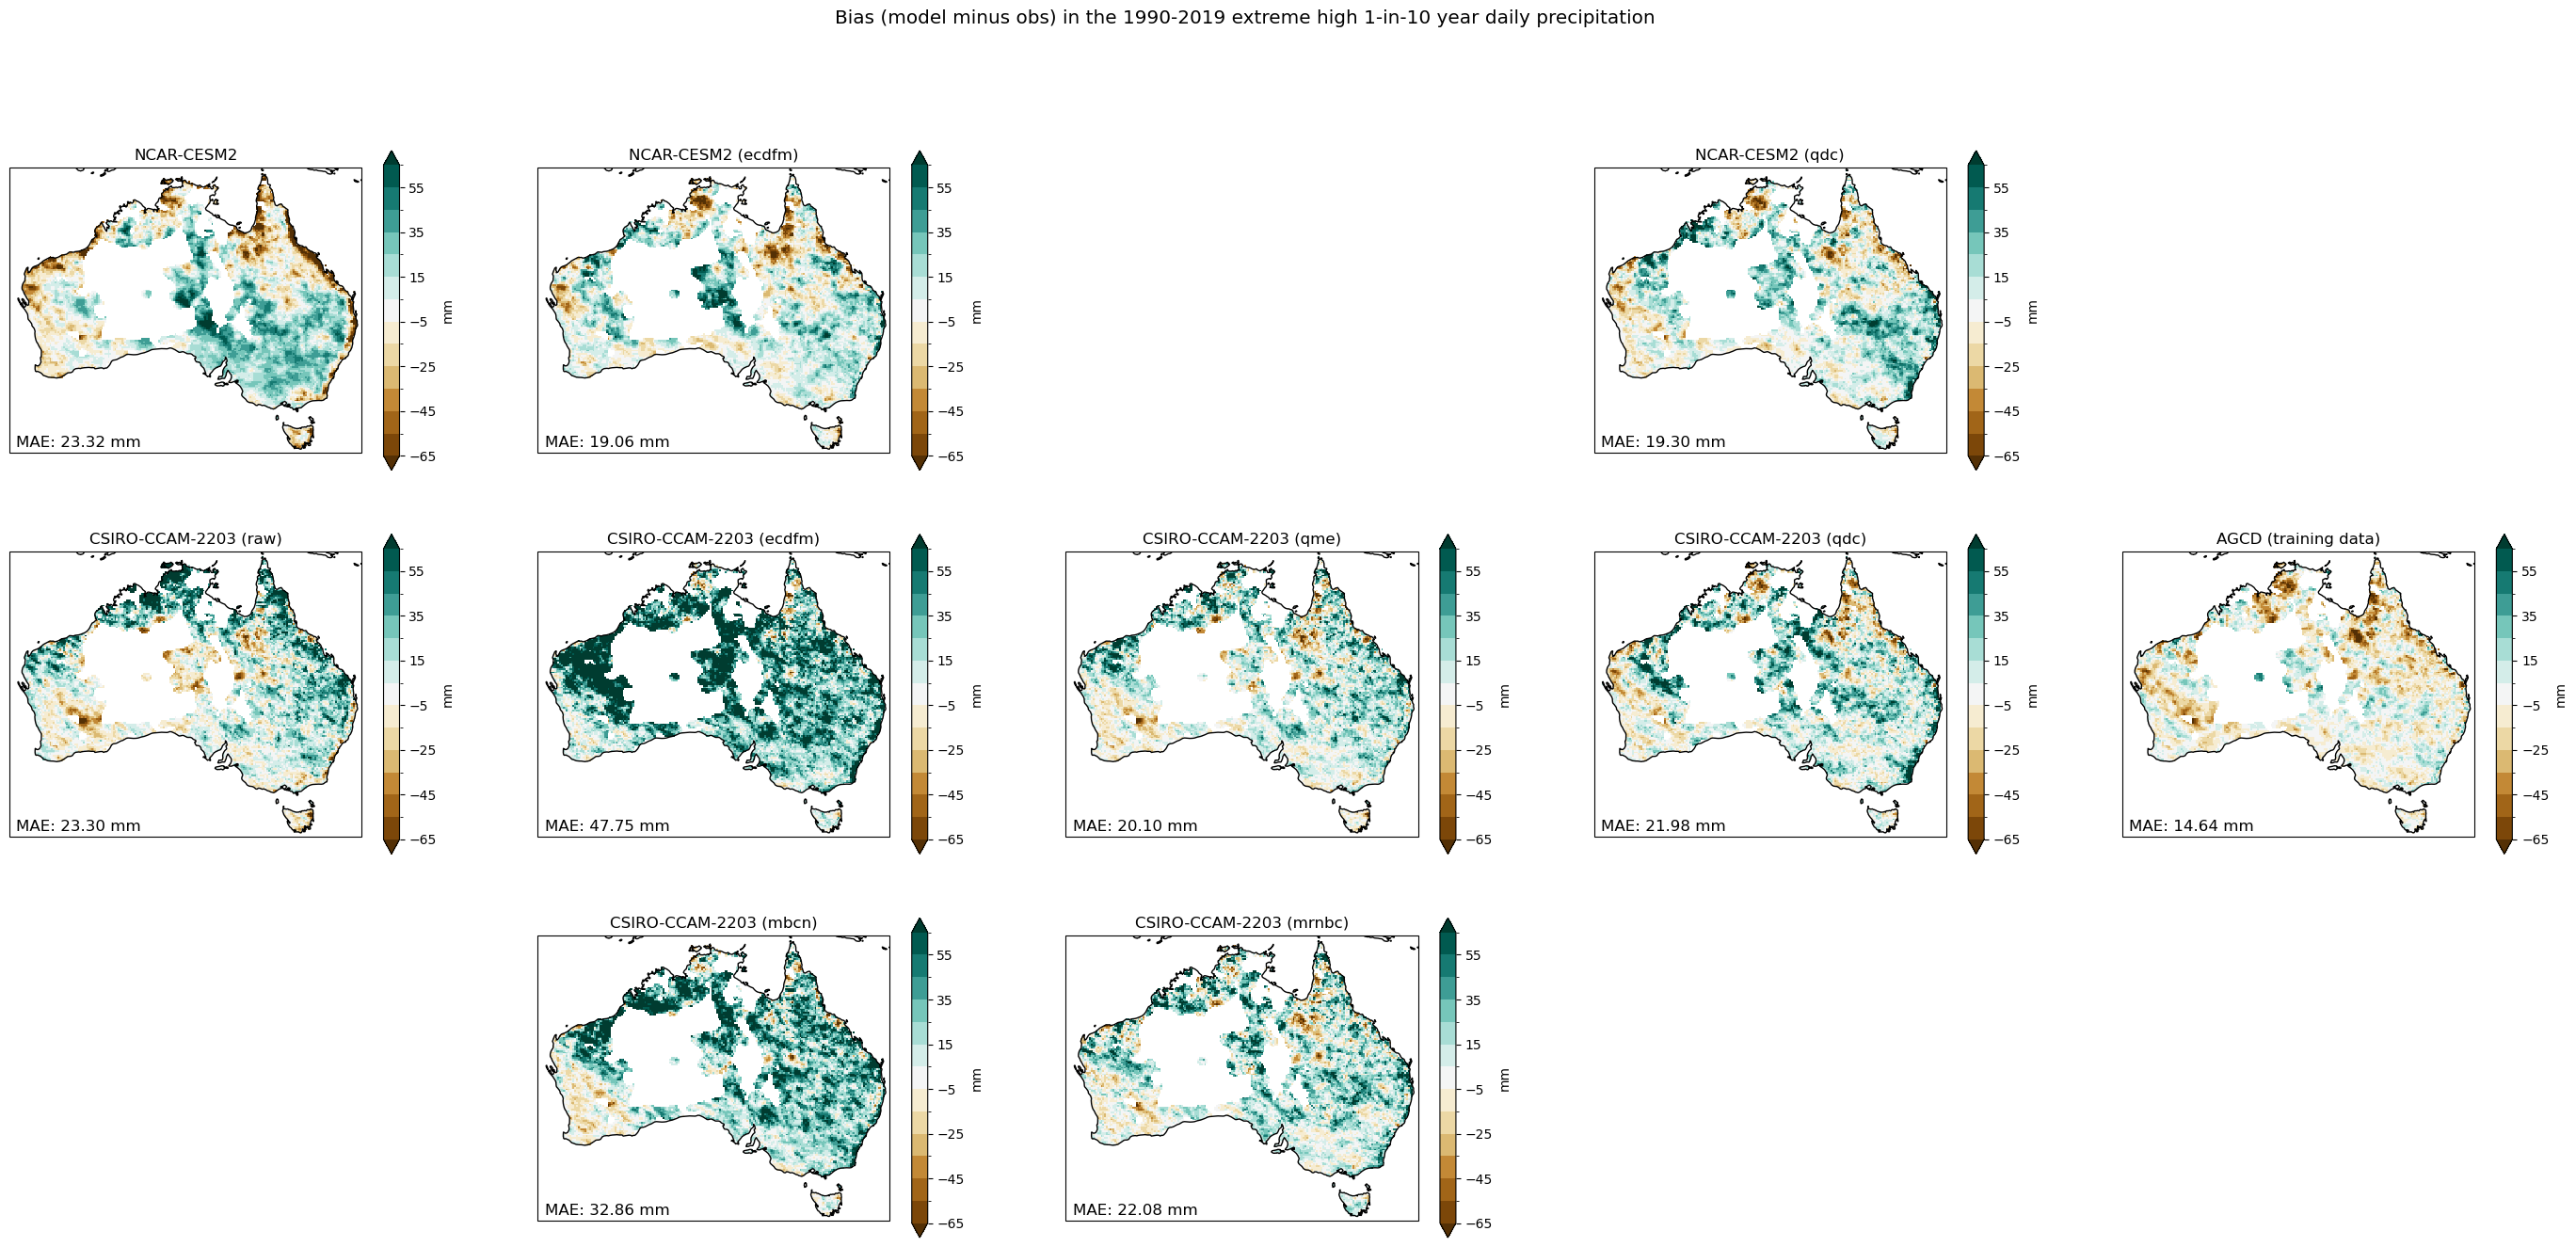

In [32]:
rcm = 'CSIRO-CCAM-2203'
plot_rcm(da_obs, da_gcm, gcm_bc_dict, variable, gcm, rcm, task, start_date, end_date, da_training_obs)

#### EC-Earth3

In [33]:
gcm = 'EC-Earth-Consortium-EC-Earth3'
task = 'xvalidation'
start_date, end_date = get_assessment_time_bounds(gcm, task)
da_obs = get_obs_data(variable, start_date, end_date)
da_gcm = get_gcm_data(variable, gcm, start_date, end_date)
gcm_bc_dict = get_bias_corrected_gcm_data(variable, gcm, task, start_date, end_date)

training_start, training_end = get_training_time_bounds(gcm)
da_training_obs = get_obs_data(variable, training_start, training_end)

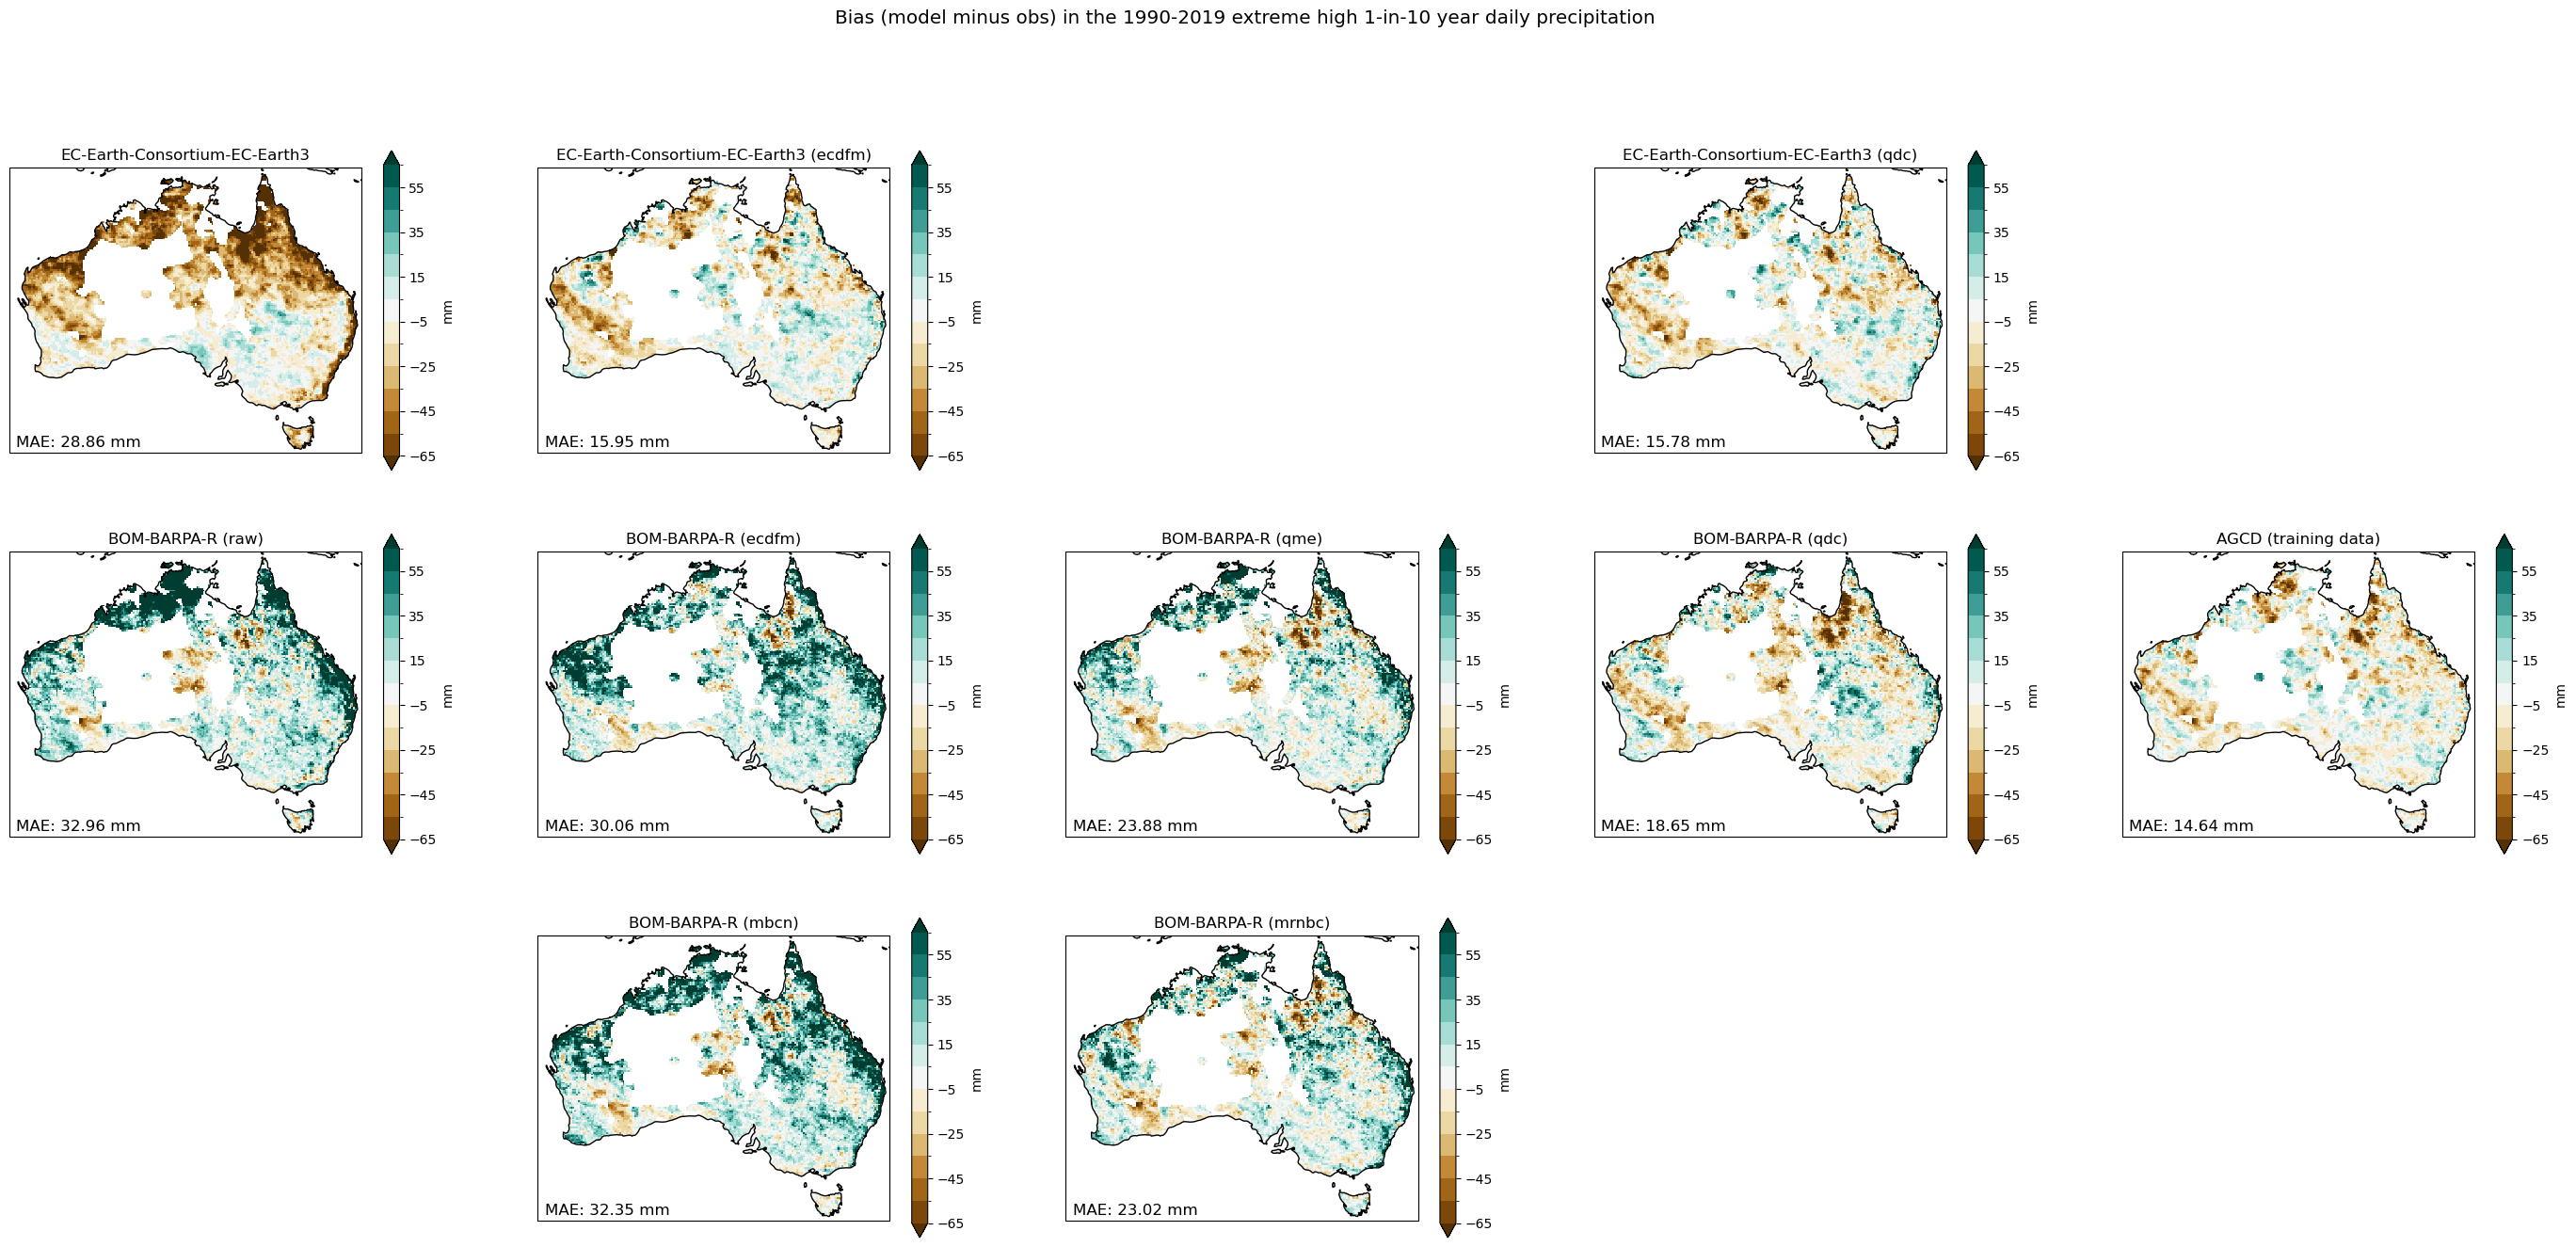

In [34]:
rcm = 'BOM-BARPA-R'
plot_rcm(da_obs, da_gcm, gcm_bc_dict, variable, gcm, rcm, task, start_date, end_date, da_training_obs)

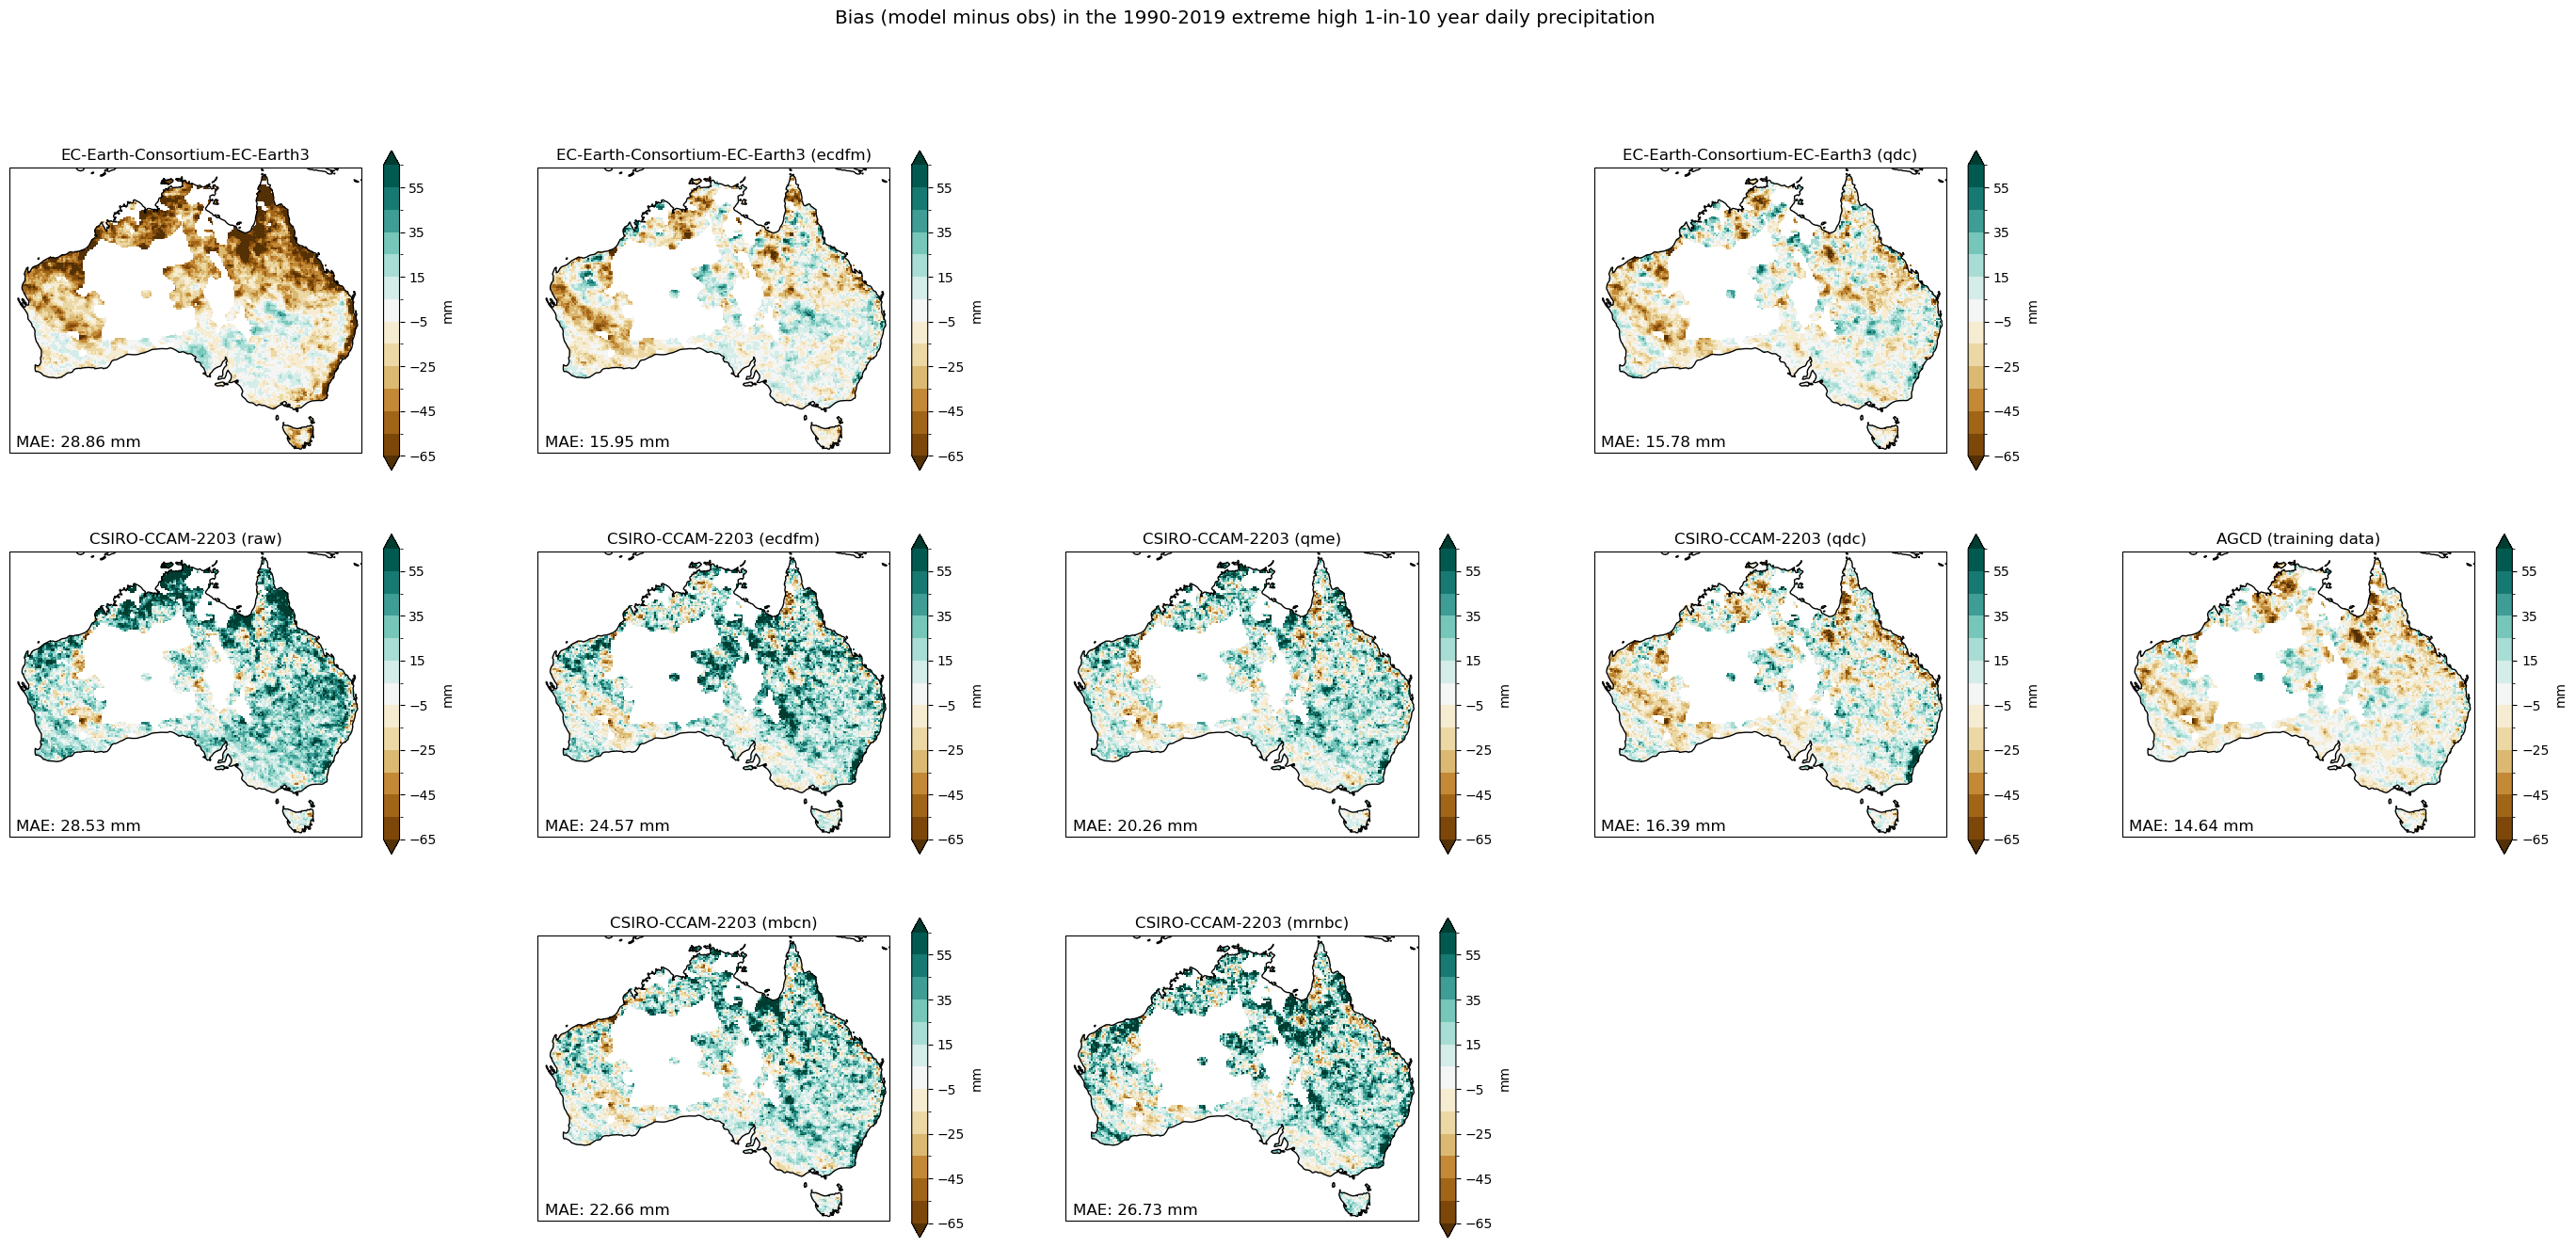

In [35]:
rcm = 'CSIRO-CCAM-2203'
plot_rcm(da_obs, da_gcm, gcm_bc_dict, variable, gcm, rcm, task, start_date, end_date, da_training_obs)